In [57]:
using Revise

using LinearAlgebra, Random, Statistics

using Pkg
Pkg.activate(".")

using Particles, Distributions, ConjugatePriors
using ConjugatePriors: NormalInverseWishart

using DataFrames, DataFramesMeta, Underscore

Revise.track("modeling.jl")
using .DotLearning

using JLD2
using Plots, StatPlots, RecipesBase

# some backwards compatibility
eye(n) = Matrix(1.0I, n, n)

eye (generic function with 1 method)

# Stickiness

Want to model "sticky" transitions between components (in order to deal with runs).  There are a few complications: need to take into account the ambiguity in same-component transitions (could be that you randomly picked the same, or that you stuck), and that affects how you count state assignments for CRP purposes (as well as sampling new values for the stickiness parameter which is important).

## `particles` state prior with stickiness: ✔

Currently: sufficient statistics are stored on components.  Need to augment those to keep track of self-transitions (in addition to total state occupations).  Ideally this could be handled with a generalized representation of the state transition prior in the particle/component somehow.  Where does that information come in?

* `fit(p::Particle, y, x::Int)`: use trickery to efficiently get the log-probability ratio, by subtracting/adding the log-count.
* `marginal_log_posterior`

How about replacing α with a prior struct?  Then need to be able to do

* prior probability given current state. (requires different sufficient statistics potentially)
* joint prior probability of a bunch of observations with labels already.

Question is then where you put the sufficient statistics...

I mean you could replace the `Particle/InfiniteParticle` distinction with this too since you really do the putative index generation based on the prior.  But is that really worth it??  Need to encapsulate the sufficient stats for the prior somehow, but why not do that _on the prior struct_ itself?  A la the `Component` abstraction...

## CRP component of sticky state prior

One subtlety is in how to properly compute the state-transition prior when there's a constant stickiness.  The generative model is simple enough: sample a "sticky" indicator with constant probability $s_i \sim \mathrm{Bernoulli}(\rho)$, and conditional on that the following state (same if $s_i = 1$, from a Chinese Restaurant Process otherwise.  The issue is that when the state doesn't change, that could be because of stickiness _or_ because that state was randomly chosen as a non-sticky transition.  And _that_ depends on how likely each state is a priori, and hence on whether other, previous assignments to that state are stickiness or not, etc....

The basic difficulty is that the CRP requries that you be able to integrate out the actual parameter which has the state probabilities.  I don't know that that's really possible here, unfortunately.

Now I see why the HDP-HMM approach is very clever.  Using a hierarchical approach lets you use the counts for transitions from each state encode the stickiness: you put your thumb on the scale with their $\kappa$ param, which then leads to more self-transitions when there's less data which gets perpetuated in the following trials via the normal CRP dynamics.

How to deal with this?  Could explicitly include the "stickiness" indicator variables in the particle state.  Or go to the hierarchical direction.  Or something where we take the limit of infinite lower-level concentration parameter, plus constant $\kappa/\alpha$ ratio?

### Stickiness/override indicator variable in state

In this formulation, there's an additional putative particle with prior weight $\rho$ generated with the same state as the predecessor, and the other particles weights are adjusted by $(1-\rho)$.  This seems quite straightforward, and could even use a special sentinal value of the state (like 0 or -1) to indicate this.  Then keep track of the number of sticking transitions and use that to sample $\rho$ (from a Beta or something).

In [8]:
@load "data/dots2014.jld2" recall pred

2-element Array{Symbol,1}:
 :recall
 :pred  

In [9]:
recall

1600×24 DataFrame. Omitted printing of 16 columns
│ Row  │ subjid1 │ block │ rep   │ respnr │ line  │ rad     │ var     │ pred  │
│      │ Int64   │ Int64 │ Int64 │ Int64  │ Int64 │ Float64 │ Float64 │ Int64 │
├──────┼─────────┼───────┼───────┼────────┼───────┼─────────┼─────────┼───────┤
│ 1    │ 1       │ 1     │ 1     │ 1      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 2    │ 1       │ 1     │ 2     │ 2      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 3    │ 1       │ 1     │ 3     │ 3      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 4    │ 1       │ 1     │ 4     │ 4      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 5    │ 1       │ 1     │ 5     │ 5      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 6    │ 1       │ 1     │ 6     │ 6      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 7    │ 1       │ 1     │ 7     │ 7      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 8    │ 1       │ 1     │ 8     │ 8      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 9    │ 1       │ 1     │ 9     │ 9      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 10   │ 1       │ 1     │ 10    │ 10     │ 1     │ 0.0     │ 0.01    │ 0     │
⋮
│ 1590 │ 8       │ 23    │ 11    │ 190    │ 17    │ 0.3     │ 0.04    │ 0     │
│ 1591 │ 8       │ 23    │ 12    │ 191    │ 17    │ 0.3     │ 0.04    │ 0     │
│ 1592 │ 8       │ 24    │ 1     │ 192    │ 23    │ 0.0     │ 0.01    │ 0     │
│ 1593 │ 8       │ 24    │ 2     │ 193    │ 23    │ 0.0     │ 0.01    │ 0     │
│ 1594 │ 8       │ 24    │ 3     │ 194    │ 23    │ 0.0     │ 0.01    │ 0     │
│ 1595 │ 8       │ 24    │ 4     │ 195    │ 23    │ 0.0     │ 0.01    │ 0     │
│ 1596 │ 8       │ 24    │ 5     │ 196    │ 23    │ 0.0     │ 0.01    │ 0     │
│ 1597 │ 8       │ 24    │ 6     │ 197    │ 23    │ 0.0     │ 0.01    │ 0     │
│ 1598 │ 8       │ 25    │ 1     │ 198    │ 4     │ 0.0     │ 0.01    │ 0     │
│ 1599 │ 8       │ 25    │ 2     │ 199    │ 4     │ 0.0     │ 0.01    │ 0     │
│ 1600 │ 8       │ 25    │ 3     │ 200    │ 4     │ 0.0     │ 0.01    │ 0     │

In [10]:
prior = NormalInverseWishart(zeros(2), 0.1, Matrix(0.3I, 2, 2), 3.)
α = 1.0
ps = ChenLiuParticles(100, prior, ChineseRestaurantProcess(α))

Particle filter with 100 particles:
InfiniteParticle{NormalInverseWishart{Float64},Distributions.MvNormalStats,ChineseRestaurantProcess}[0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle  …  0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle]

In [11]:
using JuliennedArrays

xys = @with(@where(recall, :subjid1 .== 1), hcat(:x, :y))
xy_vecs = map(vec, julienne(xys, (*,:)))

200-element Array{SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true},1}:
 [0.0318469, 0.00562752]   
 [0.0278656, 0.000370634]  
 [-0.0160184, -0.000520783]
 [0.0504518, -0.00401431]  
 [-0.0312425, -0.000984465]
 [0.00850297, -0.000448522]
 [0.0312967, 0.00292533]   
 [0.0355355, 0.00415872]   
 [-0.00730868, 0.00151658] 
 [0.0403416, -0.00260159]  
 [0.00976546, 0.00171756]  
 [0.0023686, 0.000115442]  
 [0.0546225, 0.00575101]   
 ⋮                         
 [-0.0525185, -0.20348]    
 [-0.0952235, -0.151854]   
 [-0.0422029, -0.226154]   
 [-0.235441, -0.377386]    
 [-0.0520006, -0.241261]   
 [-0.075919, -0.262445]    
 [-0.0902533, -0.158258]   
 [-0.123231, -0.187603]    
 [-0.293629, -0.247625]    
 [-0.151276, -0.262387]    
 [-0.0930733, -0.447663]   
 [-0.230315, -0.340811]    

In [12]:
filter!(ps, xy_vecs)

Fitting particles...100%|███████████████████████████████| Time: 0:00:02


Particle filter with 100 particles:
InfiniteParticle{NormalInverseWishart{Float64},Distributions.MvNormalStats,ChineseRestaurantProcess}[5+ Particle, 5+ Particle, 5+ Particle, 5+ Particle, 5+ Particle, 5+ Particle, 5+ Particle, 5+ Particle, 5+ Particle, 5+ Particle  …  5+ Particle, 5+ Particle, 5+ Particle, 5+ Particle, 5+ Particle, 6+ Particle, 5+ Particle, 5+ Particle, 5+ Particle, 5+ Particle]

In [13]:
weight.(ps.particles)

100-element Array{Float64,1}:
 0.011960909384107212
 0.01104039446729575 
 0.009513994705910205
 0.009769060639966453
 0.01446404280087056 
 0.010797684923777105
 0.006745187682651456
 0.008639350299211066
 0.014005143018143358
 0.010082362730536917
 0.00711488204496653 
 0.010391560379568914
 0.010103752575937002
 ⋮                   
 0.006678789136287951
 0.01079449981574764 
 0.006269685133375825
 0.01312245491761634 
 0.014755521236127429
 0.006891233838547523
 0.00593575842968382 
 0.014284037794157226
 0.008842342536921219
 0.006355967795048333
 0.007619506411548984
 0.009612036578792763

In [14]:
sort!(ps.particles, by=weight)

100-element Array{InfiniteParticle{NormalInverseWishart{Float64},Distributions.MvNormalStats,ChineseRestaurantProcess},1}:
 Particle with 5+ components:
  NormalInverseWishart{Float64}([-0.0198202, -0.0280925], Cholesky{Float64,Array{Float64,2}}([1.08031 -0.53876; -0.582027 1.19382], 'U', 0), 74.1, 77.0) w/ n=74
  NormalInverseWishart{Float64}([0.442743, 0.229973], Cholesky{Float64,Array{Float64,2}}([2.64883 -2.0799; -5.50932 2.4068], 'U', 0), 70.1, 73.0) w/ n=70
  NormalInverseWishart{Float64}([-0.4642, -0.204612], Cholesky{Float64,Array{Float64,2}}([1.56834 -1.25709; -1.97154 1.92869], 'U', 0), 36.1, 39.0) w/ n=36
  NormalInverseWishart{Float64}([0.611385, 0.188002], Cholesky{Float64,Array{Float64,2}}([0.695167 0.0105691; 0.00734726 0.551139], 'U', 0), 2.1, 5.0) w/ n=2
  NormalInverseWishart{Float64}([0.0458874, -0.525828], Cholesky{Float64,Array{Float64,2}}([1.57265 -0.129806; -0.204138 0.773227], 'U', 0), 18.1, 21.0) w/ n=18
  (prior: NormalInverseWishart{Float64}([0.0, 0.0], Chole

In [15]:
assignments(ps)

200×100 Array{Int64,2}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  

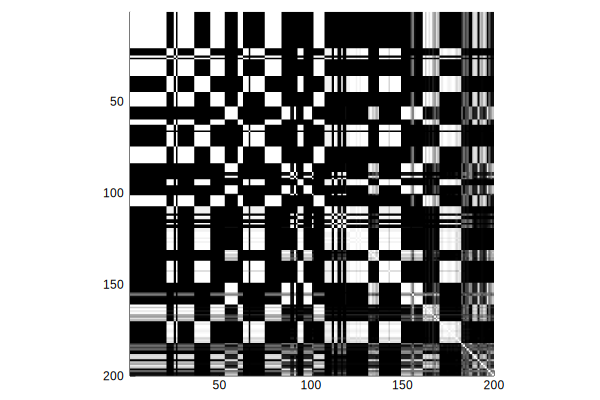

In [20]:
using Colors, Images
plot(Gray.(assignment_similarity(ps)), aspectratio=:equal)

In [21]:
sticky_ps = ChenLiuParticles(100, prior, StickyCRP(α, 0.5))
filter!(sticky_ps, xy_vecs)

Fitting particles...100%|███████████████████████████████| Time: 0:00:02


Particle filter with 100 particles:
InfiniteParticle{NormalInverseWishart{Float64},Distributions.MvNormalStats,StickyCRP}[9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 8+ Particle, 8+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle  …  9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 8+ Particle, 8+ Particle, 9+ Particle]

┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1192


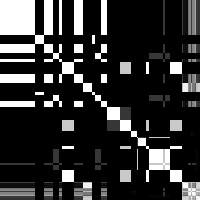

In [25]:
Gray.(assignment_similarity(sticky_ps))

In [26]:
really_sticky_ps = ChenLiuParticles(100, prior, StickyCRP(α, 0.9))
filter!(really_sticky_ps, xy_vecs)

Fitting particles...100%|███████████████████████████████| Time: 0:00:02


Particle filter with 100 particles:
InfiniteParticle{NormalInverseWishart{Float64},Distributions.MvNormalStats,StickyCRP}[9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle  …  9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle]

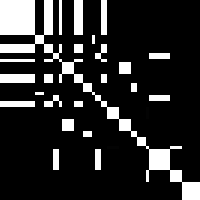

In [27]:
Gray.(assignment_similarity(really_sticky_ps))

In [28]:
barely_sticky_ps = ChenLiuParticles(100, prior, StickyCRP(α, 0.1))
filter!(barely_sticky_ps, xy_vecs)

Fitting particles...100%|███████████████████████████████| Time: 0:00:02


Particle filter with 100 particles:
InfiniteParticle{NormalInverseWishart{Float64},Distributions.MvNormalStats,StickyCRP}[7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle  …  7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle]

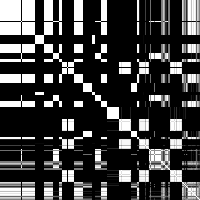

In [29]:
Gray.(assignment_similarity(barely_sticky_ps))

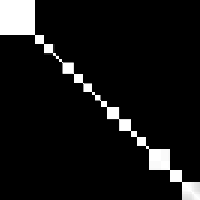

In [30]:
ps_cp = filter!(ChenLiuParticles(100, prior, ChangePoint(0.3)), xy_vecs)
Gray.(assignment_similarity(ps_cp))


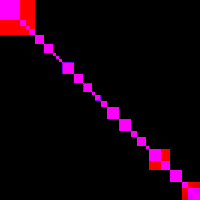

In [31]:
colorview(RGB, assignment_similarity(ps_cp), zeroarray, @_ recall |> @where(_,:subjid1.==1) |> @with(_, :block .== :block'))

In [32]:
@_ recall |>
    @where(_, :subjid1 .== 1) |>
    @by(_, [:block], x = mean(:x), y = mean(:y), n=length(:x))

25×4 DataFrame
│ Row │ block │ x          │ y           │ n     │
│     │ Int64 │ Float64    │ Float64     │ Int64 │
├─────┼───────┼────────────┼─────────────┼───────┤
│ 1   │ 1     │ 0.0170059  │ 0.000119671 │ 20    │
│ 2   │ 2     │ 0.0441005  │ 0.287878    │ 6     │
│ 3   │ 3     │ 0.00550766 │ -0.256039   │ 3     │
│ 4   │ 4     │ -0.0020067 │ -0.00224415 │ 6     │
│ 5   │ 5     │ 0.0599573  │ 0.860805    │ 9     │
│ 6   │ 6     │ 0.136758   │ -0.236607   │ 9     │
│ 7   │ 7     │ -0.552792  │ -0.208092   │ 3     │
│ 8   │ 8     │ -0.797491  │ 0.442567    │ 3     │
│ 9   │ 9     │ -0.0490483 │ -0.00694747 │ 3     │
│ 10  │ 10    │ 0.578018   │ 0.293527    │ 12    │
⋮
│ 15  │ 15    │ 0.0166456  │ -0.00106013 │ 6     │
│ 16  │ 16    │ 0.530437   │ -0.47652    │ 12    │
│ 17  │ 17    │ 0.500092   │ 0.00631989  │ 12    │
│ 18  │ 18    │ -0.542434  │ -0.635372   │ 6     │
│ 19  │ 19    │ 0.212107   │ 0.425646    │ 9     │
│ 20  │ 20    │ 0.852056   │ -0.125403   │ 3     │
│ 21  │ 21    │ -0.488265  │ 0.0469171   │ 12    │
│ 22  │ 22    │ -0.224208  │ 0.217615    │ 9     │
│ 23  │ 23    │ 0.866029   │ 0.0646224   │ 12    │
│ 24  │ 24    │ 0.0524797  │ -0.489575   │ 6     │
│ 25  │ 25    │ -0.127924  │ -0.258911   │ 12    │

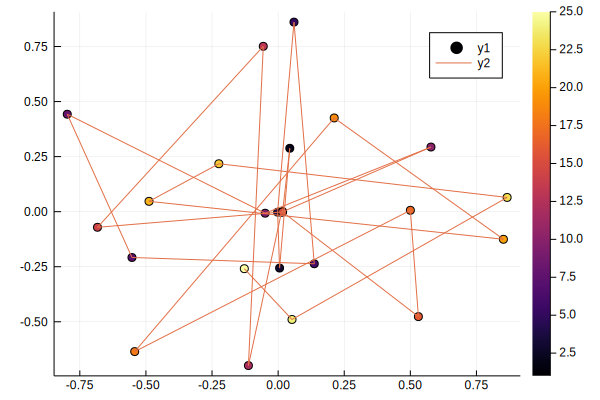

In [34]:
@_ recall |>
    @where(_, :subjid1 .== 1) |>
    @by(_, [:block], x = mean(:x), y = mean(:y), n=length(:x)) |>
    @df _ plot(:x, :y, seriestypes=[:scatter, :path], markerz = :block)

Fitting particles...100%|███████████████████████████████| Time: 0:00:23


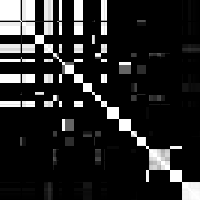

In [35]:
@_ ChenLiuParticles(1000, prior, StickyCRP(10., 0.7)) |>
    filter!(_, xy_vecs) |>
    assignment_similarity |>
    Gray.(_)

Fitting particles...100%|███████████████████████████████| Time: 0:00:21


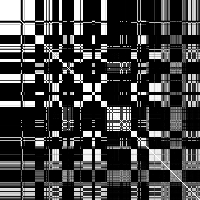

In [36]:
@_ ChenLiuParticles(1000, prior, ChineseRestaurantProcess(10.)) |>
    filter!(_, xy_vecs) |>
    assignment_similarity |>
    Gray.(_)

# Data by subject

In [37]:
sub1 = @where(recall, :subjid1 .== 1)
sub2 = @where(recall, :subjid1 .== 2)

200×24 DataFrame. Omitted printing of 16 columns
│ Row │ subjid1 │ block │ rep   │ respnr │ line  │ rad     │ var     │ pred  │
│     │ Int64   │ Int64 │ Int64 │ Int64  │ Int64 │ Float64 │ Float64 │ Int64 │
├─────┼─────────┼───────┼───────┼────────┼───────┼─────────┼─────────┼───────┤
│ 1   │ 2       │ 1     │ 1     │ 1      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 2   │ 2       │ 1     │ 2     │ 2      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 3   │ 2       │ 1     │ 3     │ 3      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 4   │ 2       │ 1     │ 4     │ 4      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 5   │ 2       │ 1     │ 5     │ 5      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 6   │ 2       │ 1     │ 6     │ 6      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 7   │ 2       │ 1     │ 7     │ 7      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 8   │ 2       │ 1     │ 8     │ 8      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 9   │ 2       │ 1     │ 9     │ 9      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 10  │ 2       │ 1     │ 10    │ 10     │ 1     │ 0.0     │ 0.01    │ 0     │
⋮
│ 190 │ 2       │ 24    │ 5     │ 190    │ 20    │ 0.5     │ 0.04    │ 0     │
│ 191 │ 2       │ 24    │ 6     │ 191    │ 20    │ 0.5     │ 0.04    │ 0     │
│ 192 │ 2       │ 25    │ 1     │ 192    │ 7     │ 0.9     │ 0.06    │ 0     │
│ 193 │ 2       │ 25    │ 2     │ 193    │ 7     │ 0.9     │ 0.06    │ 0     │
│ 194 │ 2       │ 25    │ 3     │ 194    │ 7     │ 0.9     │ 0.06    │ 0     │
│ 195 │ 2       │ 25    │ 4     │ 195    │ 7     │ 0.9     │ 0.06    │ 0     │
│ 196 │ 2       │ 25    │ 5     │ 196    │ 7     │ 0.9     │ 0.06    │ 0     │
│ 197 │ 2       │ 25    │ 6     │ 197    │ 7     │ 0.9     │ 0.06    │ 0     │
│ 198 │ 2       │ 25    │ 7     │ 198    │ 7     │ 0.9     │ 0.06    │ 0     │
│ 199 │ 2       │ 25    │ 8     │ 199    │ 7     │ 0.9     │ 0.06    │ 0     │
│ 200 │ 2       │ 25    │ 9     │ 200    │ 7     │ 0.9     │ 0.06    │ 0     │

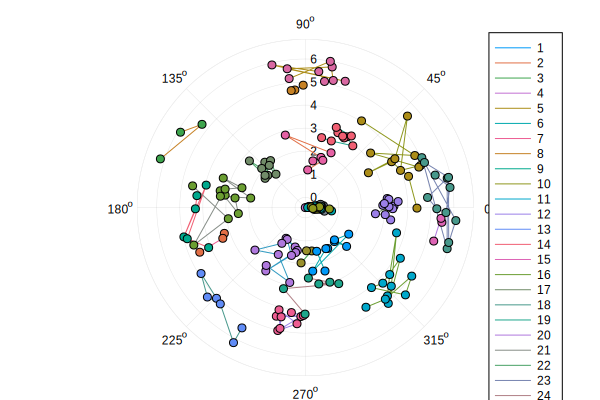

In [38]:
@with(sub1, plot(:theta, :rho, group=:block, seriestype=[^(:path), ^(:scatter)], proj=^(:polar)))

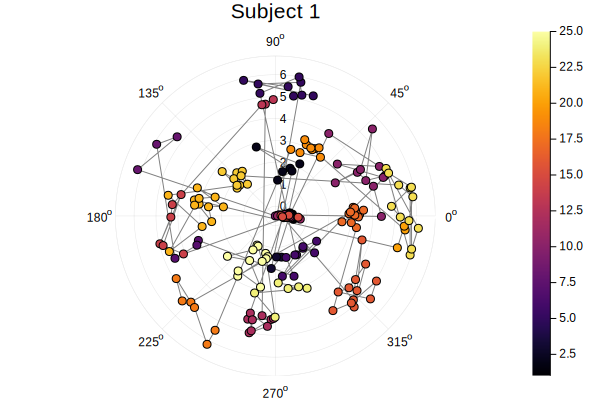

In [39]:
@df sub1 plot(:theta, :rho, seriestype=:path, proj=:polar, color="gray")
@df sub1 plot!(:theta, :rho, seriestype=:scatter, markerz=:block, legend=false)
title!("Subject 1")

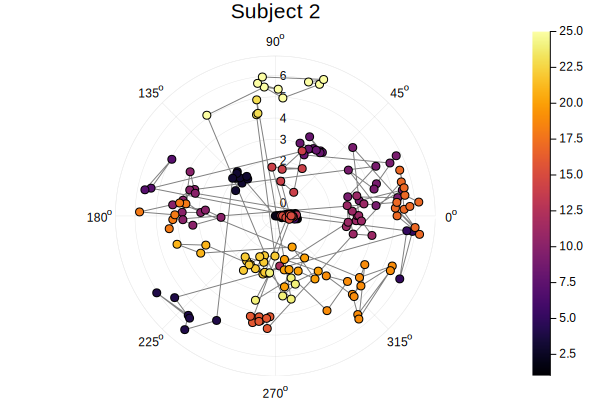

In [40]:
@df sub2 plot(:theta, :rho, seriestype=:path, proj=:polar, color="gray")
@df sub2 plot!(:theta, :rho, markerz=:block, seriestype=:scatter, legend=false)
title!("Subject 2")

The clusters are the same but they occur in different orders for each subject.

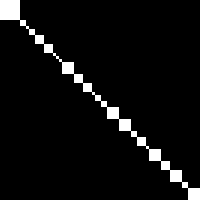

In [41]:
Gray.(@with(sub1, :block .== :block'))

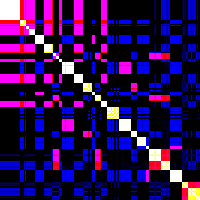

In [42]:
colorview(RGB, assignment_similarity(really_sticky_ps), @with(sub1, :block .== :block'), assignment_similarity(ps))

# Modeling recall

Recall is a combination of the actual remembered location and the category.  If the distributions are both normal then it's just the inverse-variance weighted average of the means.  I'm not sure how that works when there's uncertainty about the actual distribution...but it might be close enough when there's more than a few observations from the category.  Or not.  At the very least could sample from the posterior and then do the combination.

The precision-weighted average model of cue combination comes from a normal-normal model.  The normal-inverse-wishart model is a normal-normal model, conditioned on a sample of the variance.  So we can approximate it in one of two ways: sample a few covariance matrices and average the resulting predictions, or use the expected covariance matrix as a good guess.

Either way we have to average over particles anyway...

In [43]:
p = really_sticky_ps.particles[1]

p.assignment

9

In [44]:
c = p.components[1]

typeof(c)

Component{NormalInverseWishart{Float64},Distributions.MvNormalStats}

In [46]:
fieldnames(typeof(c))

(:prior, :suffstats)

In [47]:
using ConjugatePriors: posterior

In [48]:
post = posterior(c.prior, c.suffstats)

NormalInverseWishart{Float64}(
dim: 2
zeromean: false
mu: [0.0307026, -0.0198556]
kappa: 62.1
Lamchol: Cholesky{Float64,Array{Float64,2}}([0.756188 -0.2258; -0.170747 1.22999], 'U', 0)
nu: 65.0
)


The predictive distribution is Normal, with covariance $S_{mem} = \Sigma_n + \kappa_n^{-1}\Sigma_n = \frac{1+\kappa_n}{\kappa_n} \Sigma_N = \frac{1+\kappa_n}{\kappa_n (\nu_n - d + 1)} \Lambda_n $.  The precision is $S_{mem}^{-1} = \frac{\kappa_n (\nu_n - d + 1)}{1+\kappa_n} \Lambda_n^{-1}$

Combine that with a uncertain memory trace which is going to have MvNormal uncertainty with covariance $S_x$ and mean $x$...

Then the reconstructed (recalled) value is the inverse-variance weighted estimate:

$$\hat{x} = (S_{mem}^{-1} + S_x^{-1})^{-1} (S_{mem}^{-1} \mu + S_x^{-1} x)$$

In [50]:
using BenchmarkTools

@btime Matrix(inv($(post.Lamchol)))
@btime inv(Matrix($(post.Lamchol)))

  198.673 ns (2 allocations: 224 bytes)
  789.625 ns (9 allocations: 1.64 KiB)


2×2 Array{Float64,2}:
 1.80774   0.197374
 0.197374  0.660993

In [52]:
Matrix(inv(post.Lamchol)) ≈ inv(Matrix(post.Lamchol))

true

In [53]:
xy_vecs[end]

2-element view(::Array{Float64,2}, 200, Base.OneTo(2)) with eltype Float64:
 -0.23031513611587281
 -0.34081109457392555

The interface is that you give `recall_est` a data point, sensory uncertainty, and the `Component` it's assigned to, and it will give you the expected value of the recall.

In [56]:
recall_est(xy_vecs[end], Matrix(1.0I, 2, 2), p.components[p.assignment])

2-element Array{Float64,1}:
 -0.07217664084133114
 -0.3332105951878665 

## Filtering

Now we need to add some kind of method to filter a data point and aggregate the estimates as we go.  The `filter!` method takes a vector of observations and just calls `fit!` on each one.  Could add some kind of callback to that, or just do it manually.

In [58]:
Sx = eye(2) * sqrt(0.01)
rf = filter!(RecallFilter(ChenLiuParticles(1000, prior, StickyCRP(α, 0.9)), Sx),
             xy_vecs)

Fitting particles...100%|███████████████████████████████| Time: 0:00:22


RecallFilter{ChenLiuParticles{InfiniteParticle{NormalInverseWishart{Float64},Distributions.MvNormalStats,StickyCRP}}}(Particle filter with 1000 particles:
InfiniteParticle{NormalInverseWishart{Float64},Distributions.MvNormalStats,StickyCRP}[10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle  …  9+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 9+ Particle, 10+ Particle, 9+ Particle, 10+ Particle, 10+ Particle], [0.1 0.0; 0.0 0.1], Array{Float64,1}[[0.0308519, 0.0054517], [0.0281203, 0.0015343], [0.000618839, 0.000735409], [0.0335904, -0.00134447], [-0.00293556, -0.000292174], [0.0106303, -0.000143257], [0.0191463, 0.00110883], [0.0218261, 0.00171155], [0.00923243, 0.00108247], [0.0220913, -9.07164e-5]  …  [0.0179251, -0.102901], [-0.0902942, -0.439565], [-0.0347338, -0.346916], [-0.0394271, -0.339809], [-0.0292489, -0.228445], [-0.0378721, -0.224806], [-0.117567, -0.310199], [-0.0

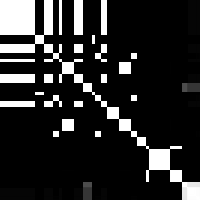

In [59]:
Gray.(assignment_similarity(rf.particles))

In [60]:
rf.recalled

200-element Array{Array{Float64,1},1}:
 [0.0308519, 0.0054517]     
 [0.0281203, 0.0015343]     
 [0.000618839, 0.000735409] 
 [0.0335904, -0.00134447]   
 [-0.00293556, -0.000292174]
 [0.0106303, -0.000143257]  
 [0.0191463, 0.00110883]    
 [0.0218261, 0.00171155]    
 [0.00923243, 0.00108247]   
 [0.0220913, -9.07164e-5]   
 [0.0149655, 0.00090813]    
 [0.0127055, 0.000552619]   
 [0.0247915, 0.00188333]    
 ⋮                          
 [-0.0120267, -0.344956]    
 [0.0058881, -0.128395]     
 [0.0179251, -0.102901]     
 [-0.0902942, -0.439565]    
 [-0.0347338, -0.346916]    
 [-0.0394271, -0.339809]    
 [-0.0292489, -0.228445]    
 [-0.0378721, -0.224806]    
 [-0.117567, -0.310199]     
 [-0.0851655, -0.313103]    
 [-0.0678084, -0.377937]    
 [-0.109553, -0.341585]     

In [61]:
norm.(rf.recalled .- xy_vecs)

200-element Array{Float64,1}:
 0.001010423730315234 
 0.0011912146639529175
 0.01668463528791313  
 0.017071442106516604 
 0.028315429033512456 
 0.0021490923461888107
 0.012285423962879063 
 0.013926142612309561 
 0.016546800178042078 
 0.01842215327790117  
 0.005262676042209398 
 0.010346093748486856 
 0.030080670442329007 
 ⋮                    
 0.1471569345886396   
 0.10379714007984214  
 0.137137426741672    
 0.15790471483957466  
 0.10705665019214314  
 0.08553864268846921  
 0.09299346326000761  
 0.09311377255525616  
 0.18685099977930225  
 0.0833229283401943   
 0.07416258990947727  
 0.1207646863023639   

In [62]:
norm.(rf.recalled) .- norm.(xy_vecs)

200-element Array{Float64,1}:
 -0.0010104237303152352 
  0.00029404787380339983
 -0.015065763391608047  
 -0.016993934076268896  
 -0.028307967259276246  
  0.002116445454439361  
 -0.012254727613489811  
 -0.013884957450503776  
  0.0018313014047507022 
 -0.018333853096314964  
  0.005077692735031079  
  0.010346053840560209  
 -0.03006147209553284   
  ⋮                     
  0.13501772486822228   
 -0.0507099184407499    
 -0.12560746265662304   
  0.003937156667413233  
  0.10184907443285246   
  0.06888356515616967   
  0.0481254024828601    
  0.003518012334366244  
 -0.05237378321892194   
  0.021607335117618864  
 -0.07326463817088963   
 -0.05261305548121237   

In [63]:
xy_resp_vecs = @_ recall |> 
    @where(_, :subjid1 .== 1) |> 
    @with(_, hcat(:x_resp, :y_resp)) |> 
    map(vec, julienne(_, (*,:)))

200-element Array{SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true},1}:
 [-0.010458, -0.0418275]  
 [0.00813932, -0.00465054]
 [-0.0685536, -0.0278827] 
 [0.070865, -0.0348544]   
 [0.0941047, -0.0859778]  
 [-0.0267245, -0.0488024] 
 [0.103403, 0.0]          
 [-0.0267275, -0.0883059] 
 [-0.0197503, 0.0139423]  
 [0.0197581, 0.00929689]  
 [0.00116183, 0.0]        
 [-0.00348551, 0.00464732]
 [0.019753, -0.0441498]   
 ⋮                        
 [0.00812914, -0.132454]  
 [-0.05229, -0.123161]    
 [-0.117332, -0.23934]    
 [-0.321814, -0.427567]   
 [-0.18474, -0.146389]    
 [-0.140581, -0.188224]   
 [-0.0360104, -0.111532]  
 [-0.161493, -0.202172]   
 [-0.245143, -0.206814]   
 [-0.268382, -0.239356]   
 [-0.0801695, -0.313703]  
 [-0.219569, -0.362502]   

In [64]:
resp_dev_rad = norm.(xy_vecs .- xy_resp_vecs)

200-element Array{Float64,1}:
 0.06357423193464015 
 0.020355267441546268
 0.05923359577910592 
 0.036983933978876386
 0.1514457131452675  
 0.05982534422633811 
 0.0721655995105227  
 0.1114737406275158  
 0.01758385344755791 
 0.023775065349672154
 0.008773394069922596
 0.007403268881481813
 0.06087668706501889 
 ⋮                   
 0.09339586351903865 
 0.05163876583912359 
 0.0762775999416561  
 0.09989193754873668 
 0.1631578247216438  
 0.09843789487454925 
 0.0715930571011938  
 0.040942781710676224
 0.06337553171415013 
 0.11934905638025581 
 0.1345804248842506  
 0.024206639880731448

In [65]:
pred_dev_rad = norm.(xy_vecs .- rf.recalled)

200-element Array{Float64,1}:
 0.001010423730315234 
 0.0011912146639529175
 0.01668463528791313  
 0.017071442106516604 
 0.028315429033512456 
 0.0021490923461888107
 0.012285423962879063 
 0.013926142612309561 
 0.016546800178042078 
 0.01842215327790117  
 0.005262676042209398 
 0.010346093748486856 
 0.030080670442329007 
 ⋮                    
 0.1471569345886396   
 0.10379714007984214  
 0.137137426741672    
 0.15790471483957466  
 0.10705665019214314  
 0.08553864268846921  
 0.09299346326000761  
 0.09311377255525616  
 0.18685099977930225  
 0.0833229283401943   
 0.07416258990947727  
 0.1207646863023639   

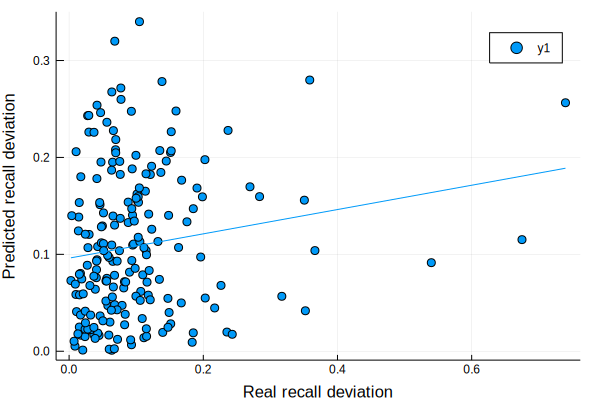

In [66]:
plot(resp_dev_rad, pred_dev_rad, seriestype = :scatter, smooth=true, 
     xlabel="Real recall deviation", ylabel="Predicted recall deviation")

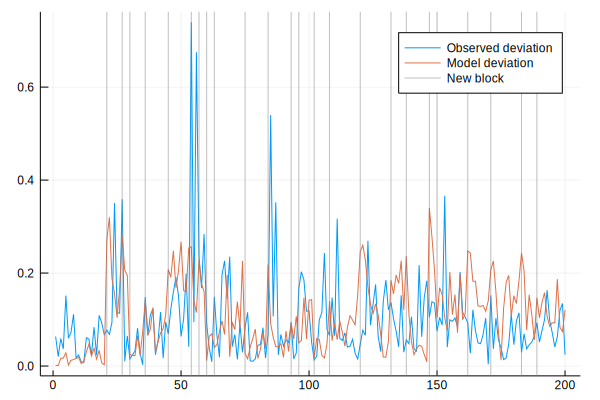

In [67]:
plot(hcat(resp_dev_rad, pred_dev_rad), lab=["Observed deviation", "Model deviation"])

@_ recall |> 
    @where(_, :subjid1.==1, :new_block .== 1) |> 
    @df _ plot!(:respnr, seriestype=:vline, color=GrayA(0.5, 0.5), label="New block")

In [68]:
by(recall, [:block, :subjid1], d -> [1:length(d[:block]); ])

1600×3 DataFrame
│ Row  │ block │ subjid1 │ x1    │
│      │ Int64 │ Int64   │ Int64 │
├──────┼───────┼─────────┼───────┤
│ 1    │ 1     │ 1       │ 1     │
│ 2    │ 1     │ 1       │ 2     │
│ 3    │ 1     │ 1       │ 3     │
│ 4    │ 1     │ 1       │ 4     │
│ 5    │ 1     │ 1       │ 5     │
│ 6    │ 1     │ 1       │ 6     │
│ 7    │ 1     │ 1       │ 7     │
│ 8    │ 1     │ 1       │ 8     │
│ 9    │ 1     │ 1       │ 9     │
│ 10   │ 1     │ 1       │ 10    │
⋮
│ 1590 │ 23    │ 8       │ 11    │
│ 1591 │ 23    │ 8       │ 12    │
│ 1592 │ 24    │ 8       │ 1     │
│ 1593 │ 24    │ 8       │ 2     │
│ 1594 │ 24    │ 8       │ 3     │
│ 1595 │ 24    │ 8       │ 4     │
│ 1596 │ 24    │ 8       │ 5     │
│ 1597 │ 24    │ 8       │ 6     │
│ 1598 │ 25    │ 8       │ 1     │
│ 1599 │ 25    │ 8       │ 2     │
│ 1600 │ 25    │ 8       │ 3     │

In [69]:
cor(resp_dev_rad, pred_dev_rad)

0.16198639336871976

In [70]:
pred_radius = norm.(rf.recalled)

200-element Array{Float64,1}:
 0.0313298607059579   
 0.028162078409194276 
 0.0009611393777458094
 0.03361733782695382  
 0.002950063563972001 
 0.01063123490985576  
 0.019178373647159522 
 0.02189307375655429  
 0.009295668235760593 
 0.022091502449026457 
 0.014993045689656159 
 0.01271746249262945  
 0.02486289876548024  
 ⋮                    
 0.34516591172676087  
 0.12853037846934265  
 0.10445100758271166  
 0.4487433916206423   
 0.34865064468545454  
 0.3420889404677172   
 0.2303100658401527   
 0.22797422857686622  
 0.3317307564390583   
 0.3244791918214957   
 0.3839715978378165   
 0.35872289493979115  

In [72]:
reduce(hcat, rf.recalled)'

200×2 Adjoint{Float64,Array{Float64,2}}:
  0.0308519     0.0054517  
  0.0281203     0.0015343  
  0.000618839   0.000735409
  0.0335904    -0.00134447 
 -0.00293556   -0.000292174
  0.0106303    -0.000143257
  0.0191463     0.00110883 
  0.0218261     0.00171155 
  0.00923243    0.00108247 
  0.0220913    -9.07164e-5 
  0.0149655     0.00090813 
  0.0127055     0.000552619
  0.0247915     0.00188333 
  ⋮                        
 -0.0120267    -0.344956   
  0.0058881    -0.128395   
  0.0179251    -0.102901   
 -0.0902942    -0.439565   
 -0.0347338    -0.346916   
 -0.0394271    -0.339809   
 -0.0292489    -0.228445   
 -0.0378721    -0.224806   
 -0.117567     -0.310199   
 -0.0851655    -0.313103   
 -0.0678084    -0.377937   
 -0.109553     -0.341585   

# Plots

## Bias by radius

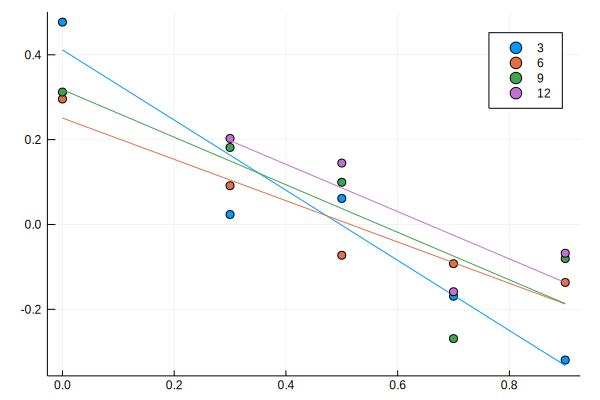

In [73]:
plot_bias_by_radius = d -> @_ d |> 
    @where(_, :block .> 1) |>
    @by(_, [:rad, :rep_number], new_rho_bias = mean(:new_rho_bias)) |>
    @with(_, plot(:rad, :new_rho_bias, group=:rep_number, smooth=true, seriestype=^([:scatter])))
plot_bias_by_radius(recall)

## Just first subject

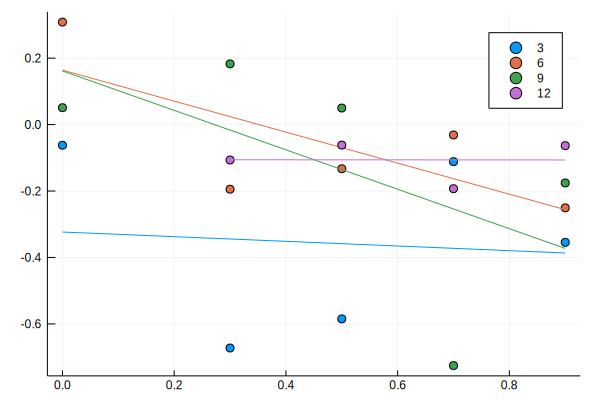

In [74]:
@_ recall |>
    @where(_, :subjid1 .== 1) |>
    plot_bias_by_radius

Extremely noisy!

## All subjects

In [75]:
methods(model_recall)

# 1 method for generic function "model_recall":
[1] model_recall(d::AbstractDataFrame, ps::ParticleFilter, Sx::Array{T,2} where T; add) in Main.DotLearning at /home/dave/work/dots-location-memory-pernille/modeling.jl:95

In [76]:
@_ recall |>
    @where(_, :subjid1 .== 1) |>
    model_recall(_, ChenLiuParticles(100, prior, StickyCRP(1.0, 0.9)), eye(2))

200×27 DataFrame. Omitted printing of 19 columns
│ Row │ subjid1 │ block │ rep   │ respnr │ line  │ rad     │ var     │ pred  │
│     │ Int64   │ Int64 │ Int64 │ Int64  │ Int64 │ Float64 │ Float64 │ Int64 │
├─────┼─────────┼───────┼───────┼────────┼───────┼─────────┼─────────┼───────┤
│ 1   │ 1       │ 1     │ 1     │ 1      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 2   │ 1       │ 1     │ 2     │ 2      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 3   │ 1       │ 1     │ 3     │ 3      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 4   │ 1       │ 1     │ 4     │ 4      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 5   │ 1       │ 1     │ 5     │ 5      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 6   │ 1       │ 1     │ 6     │ 6      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 7   │ 1       │ 1     │ 7     │ 7      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 8   │ 1       │ 1     │ 8     │ 8      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 9   │ 1       │ 1     │ 9     │ 9      │ 1     │ 0.0     │ 0.01    │ 0     │
│ 10  │ 1       │ 1     │ 10    │ 10     │ 1     │ 0.0     │ 0.01    │ 0     │
⋮
│ 190 │ 1       │ 25    │ 2     │ 190    │ 17    │ 0.3     │ 0.04    │ 0     │
│ 191 │ 1       │ 25    │ 3     │ 191    │ 17    │ 0.3     │ 0.04    │ 0     │
│ 192 │ 1       │ 25    │ 4     │ 192    │ 17    │ 0.3     │ 0.04    │ 0     │
│ 193 │ 1       │ 25    │ 5     │ 193    │ 17    │ 0.3     │ 0.04    │ 0     │
│ 194 │ 1       │ 25    │ 6     │ 194    │ 17    │ 0.3     │ 0.04    │ 0     │
│ 195 │ 1       │ 25    │ 7     │ 195    │ 17    │ 0.3     │ 0.04    │ 0     │
│ 196 │ 1       │ 25    │ 8     │ 196    │ 17    │ 0.3     │ 0.04    │ 0     │
│ 197 │ 1       │ 25    │ 9     │ 197    │ 17    │ 0.3     │ 0.04    │ 0     │
│ 198 │ 1       │ 25    │ 10    │ 198    │ 17    │ 0.3     │ 0.04    │ 0     │
│ 199 │ 1       │ 25    │ 11    │ 199    │ 17    │ 0.3     │ 0.04    │ 0     │
│ 200 │ 1       │ 25    │ 12    │ 200    │ 17    │ 0.3     │ 0.04    │ 0     │

In [77]:
recall_mod = by(recall, :subjid1, 
                d->model_recall(d, ChenLiuParticles(100, prior, StickyCRP(1.0, 0.9)), eye(2).*0.00000001))

1600×28 DataFrame. Omitted printing of 21 columns
│ Row  │ subjid1 │ subjid1_1 │ block │ rep   │ respnr │ line  │ rad     │
│      │ Int64   │ Int64     │ Int64 │ Int64 │ Int64  │ Int64 │ Float64 │
├──────┼─────────┼───────────┼───────┼───────┼────────┼───────┼─────────┤
│ 1    │ 1       │ 1         │ 1     │ 1     │ 1      │ 1     │ 0.0     │
│ 2    │ 1       │ 1         │ 1     │ 2     │ 2      │ 1     │ 0.0     │
│ 3    │ 1       │ 1         │ 1     │ 3     │ 3      │ 1     │ 0.0     │
│ 4    │ 1       │ 1         │ 1     │ 4     │ 4      │ 1     │ 0.0     │
│ 5    │ 1       │ 1         │ 1     │ 5     │ 5      │ 1     │ 0.0     │
│ 6    │ 1       │ 1         │ 1     │ 6     │ 6      │ 1     │ 0.0     │
│ 7    │ 1       │ 1         │ 1     │ 7     │ 7      │ 1     │ 0.0     │
│ 8    │ 1       │ 1         │ 1     │ 8     │ 8      │ 1     │ 0.0     │
│ 9    │ 1       │ 1         │ 1     │ 9     │ 9      │ 1     │ 0.0     │
│ 10   │ 1       │ 1         │ 1     │ 10    │ 10     │ 1     │ 0.0     │
⋮
│ 1590 │ 8       │ 8         │ 23    │ 11    │ 190    │ 17    │ 0.3     │
│ 1591 │ 8       │ 8         │ 23    │ 12    │ 191    │ 17    │ 0.3     │
│ 1592 │ 8       │ 8         │ 24    │ 1     │ 192    │ 23    │ 0.0     │
│ 1593 │ 8       │ 8         │ 24    │ 2     │ 193    │ 23    │ 0.0     │
│ 1594 │ 8       │ 8         │ 24    │ 3     │ 194    │ 23    │ 0.0     │
│ 1595 │ 8       │ 8         │ 24    │ 4     │ 195    │ 23    │ 0.0     │
│ 1596 │ 8       │ 8         │ 24    │ 5     │ 196    │ 23    │ 0.0     │
│ 1597 │ 8       │ 8         │ 24    │ 6     │ 197    │ 23    │ 0.0     │
│ 1598 │ 8       │ 8         │ 25    │ 1     │ 198    │ 4     │ 0.0     │
│ 1599 │ 8       │ 8         │ 25    │ 2     │ 199    │ 4     │ 0.0     │
│ 1600 │ 8       │ 8         │ 25    │ 3     │ 200    │ 4     │ 0.0     │

# Sanity checks

## Visualizing recall bias


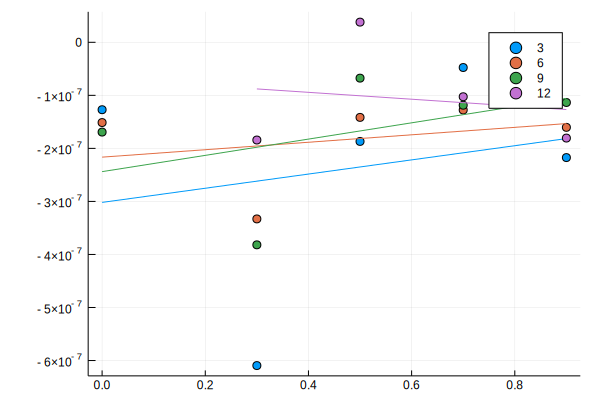

In [78]:
@_ hcat(recall, recall_mod, makeunique=true) |>
    @transform(_, pred_rho_bias = :rho_mod.*2π .- abs.(:rho)) |> 
    @where(_, :block .> 1) |>
    @by(_, [:rad, :rep_number], pred_rho_bias = mean(:pred_rho_bias)) |>
    @df(_, plot(:rad, :pred_rho_bias, group=:rep_number, smooth=true, seriestype=:scatter))


Okay that's more like it.  A mess.  (and very small biases overall, which makes sense because of the very small $S_x$).  So what happens if we run it with ...

## Reasonable amount of uncertainty ($S_x$)

In [79]:
recall_mod_Sx1 = by(recall, :subjid1, 
                    d->model_recall(d, ChenLiuParticles(100, prior, StickyCRP(1.0, 0.9)), eye(2)))

1600×28 DataFrame. Omitted printing of 21 columns
│ Row  │ subjid1 │ subjid1_1 │ block │ rep   │ respnr │ line  │ rad     │
│      │ Int64   │ Int64     │ Int64 │ Int64 │ Int64  │ Int64 │ Float64 │
├──────┼─────────┼───────────┼───────┼───────┼────────┼───────┼─────────┤
│ 1    │ 1       │ 1         │ 1     │ 1     │ 1      │ 1     │ 0.0     │
│ 2    │ 1       │ 1         │ 1     │ 2     │ 2      │ 1     │ 0.0     │
│ 3    │ 1       │ 1         │ 1     │ 3     │ 3      │ 1     │ 0.0     │
│ 4    │ 1       │ 1         │ 1     │ 4     │ 4      │ 1     │ 0.0     │
│ 5    │ 1       │ 1         │ 1     │ 5     │ 5      │ 1     │ 0.0     │
│ 6    │ 1       │ 1         │ 1     │ 6     │ 6      │ 1     │ 0.0     │
│ 7    │ 1       │ 1         │ 1     │ 7     │ 7      │ 1     │ 0.0     │
│ 8    │ 1       │ 1         │ 1     │ 8     │ 8      │ 1     │ 0.0     │
│ 9    │ 1       │ 1         │ 1     │ 9     │ 9      │ 1     │ 0.0     │
│ 10   │ 1       │ 1         │ 1     │ 10    │ 10     │ 1     │ 0.0     │
⋮
│ 1590 │ 8       │ 8         │ 23    │ 11    │ 190    │ 17    │ 0.3     │
│ 1591 │ 8       │ 8         │ 23    │ 12    │ 191    │ 17    │ 0.3     │
│ 1592 │ 8       │ 8         │ 24    │ 1     │ 192    │ 23    │ 0.0     │
│ 1593 │ 8       │ 8         │ 24    │ 2     │ 193    │ 23    │ 0.0     │
│ 1594 │ 8       │ 8         │ 24    │ 3     │ 194    │ 23    │ 0.0     │
│ 1595 │ 8       │ 8         │ 24    │ 4     │ 195    │ 23    │ 0.0     │
│ 1596 │ 8       │ 8         │ 24    │ 5     │ 196    │ 23    │ 0.0     │
│ 1597 │ 8       │ 8         │ 24    │ 6     │ 197    │ 23    │ 0.0     │
│ 1598 │ 8       │ 8         │ 25    │ 1     │ 198    │ 4     │ 0.0     │
│ 1599 │ 8       │ 8         │ 25    │ 2     │ 199    │ 4     │ 0.0     │
│ 1600 │ 8       │ 8         │ 25    │ 3     │ 200    │ 4     │ 0.0     │

### Bias as a function of radius and run length

Qualitatively similar: bias has a negative slope (shrinkage), more bias for shorter runs.  But the slope difference isn't there (although it's not clear whether it's _really_ there in the data), and the bias is zero at radius zero, _not_ at the average radius.

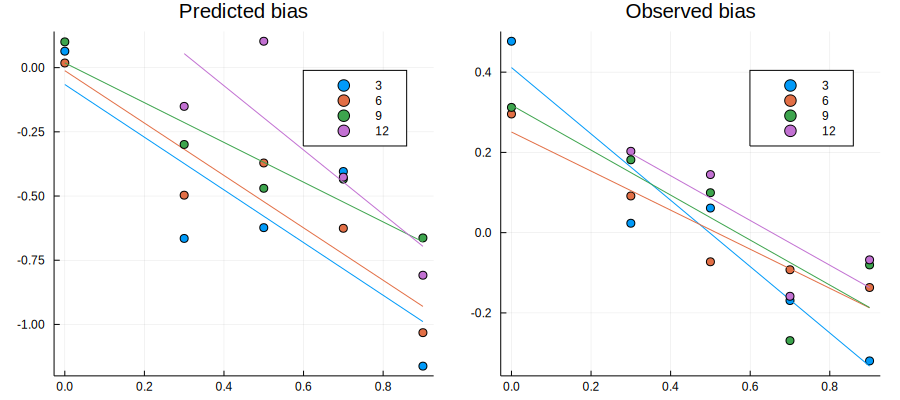

In [80]:
@_ recall_mod_Sx1 |>
    @transform(_, pred_rho_bias = :rho_mod.*2π .- abs.(:rho)) |> 
    @where(_, :block .> 1) |>
    @by(_, [:rad, :rep_number], pred_rho_bias = mean(:pred_rho_bias), new_rho_bias = mean(:new_rho_bias)) |>
    @df(_, plot(plot(:rad, :pred_rho_bias, group=:rep_number, smooth=true, seriestype=:scatter, 
                     title="Predicted bias"),
                plot(:rad, :new_rho_bias, group=:rep_number, smooth=true, seriestype=:scatter, 
                     title="Observed bias"),
                size=(900,400)))

However it looks like the _relative_ effect of the block length is exaggerated in the predictions:

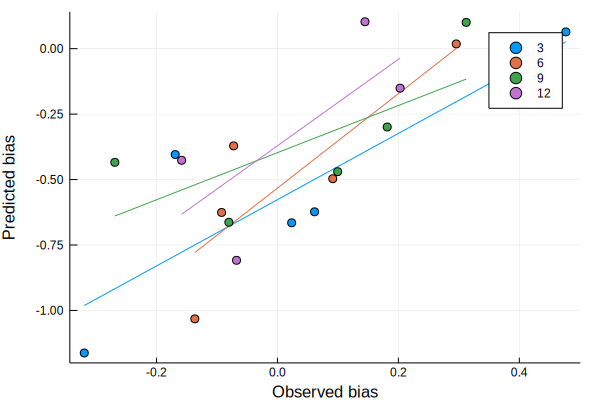

In [81]:
@_ recall_mod_Sx1 |>
    @transform(_, pred_rho_bias = :rho_mod.*2π .- abs.(:rho)) |> 
    @where(_, :block .> 1) |>
    @by(_, [:rad, :rep_number], pred_rho_bias = mean(:pred_rho_bias), rho_bias = mean(:new_rho_bias)) |>
    @df(_, scatter(:rho_bias, :pred_rho_bias, group=:rep_number, smooth=true,
                   xlabel="Observed bias", ylabel="Predicted bias"))


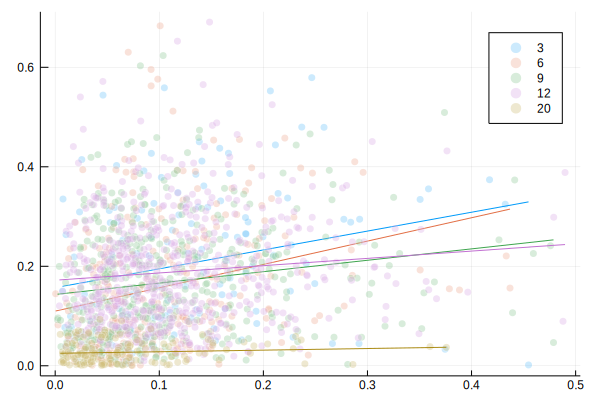

In [85]:
@_ recall_mod_Sx1 |>
    @transform(_, err_resp = .√((:x .- :x_resp).^2 + (:y .- :y_resp).^2),
                  err_mod = .√((:x .- :x_mod).^2 + (:y .- :y_mod).^2)) |>
    @where(_, :err_resp .< 0.5)|>
    @df _ scatter(:err_resp, :err_mod, smooth=true, markeralpha=0.2, markerstrokecolor=:white, group=:rep_number)

In [88]:
using Distances
using Distances: colwise

@_ recall_mod_Sx1 |>
    @transform(_, err_resp = .√((:x .- :x_resp).^2 + (:y .- :y_resp).^2),
                  err_resp2 = colwise(Euclidean(), hcat(:x, :y)', hcat(:x_resp, :y_resp)'))

1600×30 DataFrame. Omitted printing of 23 columns
│ Row  │ subjid1 │ subjid1_1 │ block │ rep   │ respnr │ line  │ rad     │
│      │ Int64   │ Int64     │ Int64 │ Int64 │ Int64  │ Int64 │ Float64 │
├──────┼─────────┼───────────┼───────┼───────┼────────┼───────┼─────────┤
│ 1    │ 1       │ 1         │ 1     │ 1     │ 1      │ 1     │ 0.0     │
│ 2    │ 1       │ 1         │ 1     │ 2     │ 2      │ 1     │ 0.0     │
│ 3    │ 1       │ 1         │ 1     │ 3     │ 3      │ 1     │ 0.0     │
│ 4    │ 1       │ 1         │ 1     │ 4     │ 4      │ 1     │ 0.0     │
│ 5    │ 1       │ 1         │ 1     │ 5     │ 5      │ 1     │ 0.0     │
│ 6    │ 1       │ 1         │ 1     │ 6     │ 6      │ 1     │ 0.0     │
│ 7    │ 1       │ 1         │ 1     │ 7     │ 7      │ 1     │ 0.0     │
│ 8    │ 1       │ 1         │ 1     │ 8     │ 8      │ 1     │ 0.0     │
│ 9    │ 1       │ 1         │ 1     │ 9     │ 9      │ 1     │ 0.0     │
│ 10   │ 1       │ 1         │ 1     │ 10    │ 10     │ 1     │ 0.0     │
⋮
│ 1590 │ 8       │ 8         │ 23    │ 11    │ 190    │ 17    │ 0.3     │
│ 1591 │ 8       │ 8         │ 23    │ 12    │ 191    │ 17    │ 0.3     │
│ 1592 │ 8       │ 8         │ 24    │ 1     │ 192    │ 23    │ 0.0     │
│ 1593 │ 8       │ 8         │ 24    │ 2     │ 193    │ 23    │ 0.0     │
│ 1594 │ 8       │ 8         │ 24    │ 3     │ 194    │ 23    │ 0.0     │
│ 1595 │ 8       │ 8         │ 24    │ 4     │ 195    │ 23    │ 0.0     │
│ 1596 │ 8       │ 8         │ 24    │ 5     │ 196    │ 23    │ 0.0     │
│ 1597 │ 8       │ 8         │ 24    │ 6     │ 197    │ 23    │ 0.0     │
│ 1598 │ 8       │ 8         │ 25    │ 1     │ 198    │ 4     │ 0.0     │
│ 1599 │ 8       │ 8         │ 25    │ 2     │ 199    │ 4     │ 0.0     │
│ 1600 │ 8       │ 8         │ 25    │ 3     │ 200    │ 4     │ 0.0     │

## Plotting single-trial deviations

This shows the (predicted) deviation for subject 1, over the course of the experiment.  You can see that rather extreme shrinkage towards inferred clusters is predicted with this level of sensory uncertainty (and stickiness, likely):

In [90]:
include("plots.jl")

In [91]:
using RecipesBase

@userplot Arrows
@recipe function f(p::Arrows)
    x, xend, y, yend = p.args
    seriestype := :quiver
    
    quiver := (xend.-x, yend.-y)
    aspect_ratio --> :equal
    x,y
end

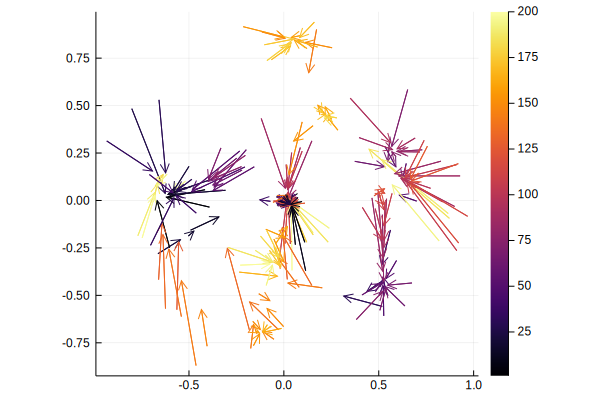

In [92]:
@_ recall_mod_Sx1 |>
    @where(_, :subjid1.==1) |>
    @df(_, arrows(:x, :x_mod, :y, :y_mod, linez=:respnr))

This does not match the qualitative patterns we see in the behavior of one subject:

In [93]:
@userplot ArrowsModResp
@recipe function f(p::ArrowsModResp)
    x, y, x_mod, y_mod, x_resp, y_resp = p.args
    layout := @layout [pred{0.45w} obs]

    size --> (900, 400)
    aspect_ratio --> :equal
    link --> :y
    
    @series begin
        seriestype := :quiver
        subplot := 1
        legend := false
        quiver := (x_mod .- x, y_mod .- y)
        title := "Predicted"
        x,y
    end
    
    @series begin
        seriestype := :quiver
        subplot := 2
        quiver := (x_resp .- x, y_resp .- y)
        title := "Observed"
        x,y
    end
end

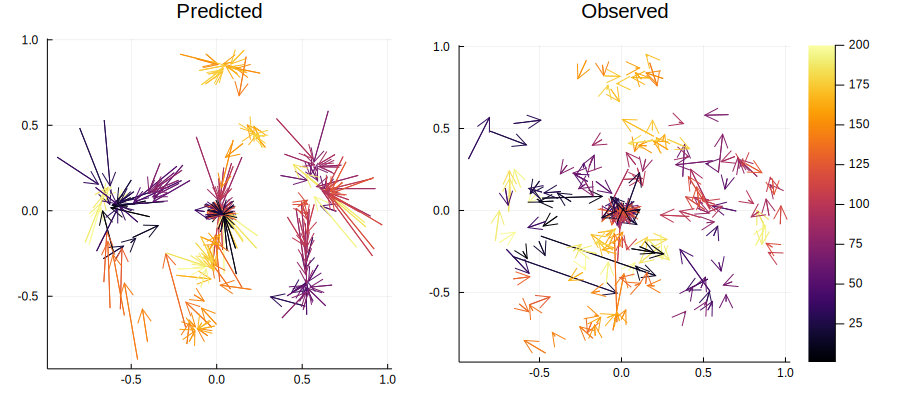

In [94]:

@_ recall_mod_Sx1 |>
    @where(_, :subjid1 .== 1) |>
    @df _ arrowsmodresp(:x, :y, :x_mod, :y_mod, :x_resp, :y_resp, 
                        linez=:respnr, size=(900, 400))


In [95]:
rho(x) = sqrt(mapreduce(x->x^2, +, x))

rho (generic function with 1 method)

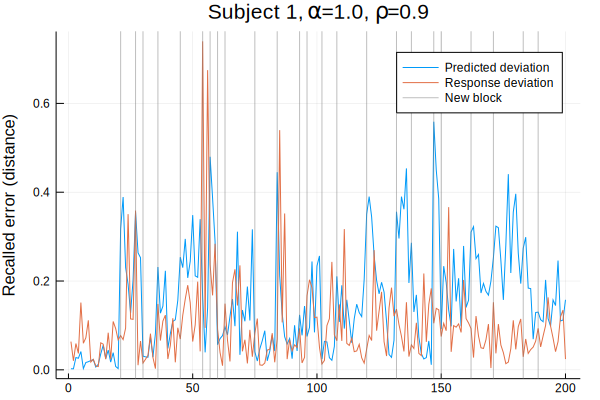

In [96]:
@_ recall_mod_Sx1 |>
    @where(_, :subjid1.==1) |>
    @transform(_, 
               dev_mod = map(rho, zip(:x.-:x_mod, :y.-:y_mod)), 
               dev_resp = map(rho, zip(:x.-:x_resp, :y.-:y_resp))) |>
    @df _ plot(hcat(:dev_mod, :dev_resp), labels=["Predicted deviation", "Response deviation"])

@_ recall_mod_Sx1 |>
    @where(_, :subjid1.==1, :new_block .== 1) |>
    @df _ plot!(:respnr, seriestype=:vline, label="New block", color=GrayA(0.5, 0.5))

title!("Subject 1, \\alpha=1.0, \\rho=0.9")
ylabel!("Recalled error (distance)")

# Alternative models

## Updating with correct breaks

Another sanity check is what happens when we _know_ where the block breaks are.

In [97]:
p = InfiniteParticle(prior, StickyCRP(1., 0.9))

Particle with 0+ components:
  (prior: NormalInverseWishart{Float64}([0.0, 0.0], Cholesky{Float64,Array{Float64,2}}([0.547723 0.0; 0.0 0.547723], 'U', 0), 0.1, 3.0) w/ n=0)


In [100]:
recall1 = @where(recall, :subjid1 .== 1)
xyi = @with recall1 map((x,y,i) -> ([x,y], round(Int,i)), :x, :y, :block)
p = foldl((p, xyi) -> fit(p, xyi[1], xyi[2]), 
      init=InfiniteParticle(prior, StickyCRP(1., 0.9)), 
      xyi)

Particle with 25+ components:
  NormalInverseWishart{Float64}([0.0169213, 0.000119075], Cholesky{Float64,Array{Float64,2}}([0.562545 0.000885396; 0.000498075 0.548087], 'U', 0), 20.1, 23.0) w/ n=20
  NormalInverseWishart{Float64}([0.0433775, 0.283159], Cholesky{Float64,Array{Float64,2}}([0.585827 -0.0310601; -0.0181959 0.583515], 'U', 0), 6.1, 9.0) w/ n=6
  NormalInverseWishart{Float64}([0.00532999, -0.247779], Cholesky{Float64,Array{Float64,2}}([0.549268 0.00414004; 0.00227399 0.557592], 'U', 0), 3.1, 6.0) w/ n=3
  NormalInverseWishart{Float64}([-0.00197381, -0.00220736], Cholesky{Float64,Array{Float64,2}}([0.554725 0.00189332; 0.00105027 0.547856], 'U', 0), 6.1, 9.0) w/ n=6
  NormalInverseWishart{Float64}([0.0592984, 0.851346], Cholesky{Float64,Array{Float64,2}}([0.715472 -0.0228166; -0.0163246 0.628987], 'U', 0), 9.1, 12.0) w/ n=9
  NormalInverseWishart{Float64}([0.135255, -0.234007], Cholesky{Float64,Array{Float64,2}}([0.581715 0.0414961; 0.0241389 0.5962], 'U', 0), 9.1, 12.0) w/ n

In [101]:
recall_est(xyi[end][1], Sx, p)

2-element Array{Float64,1}:
 -0.1514115397943215 
 -0.27789623870279656

In [102]:
xyi[end]

([-0.230315, -0.340811], 25)

In [103]:
filter!(KnownFilter(prior), xyi)

KnownFilter{InfiniteParticle{NormalInverseWishart{Float64},Distributions.MvNormalStats,ChineseRestaurantProcess}}(Particle with 25+ components:
  NormalInverseWishart{Float64}([0.0169213, 0.000119075], Cholesky{Float64,Array{Float64,2}}([0.562545 0.000885396; 0.000498075 0.548087], 'U', 0), 20.1, 23.0) w/ n=20
  NormalInverseWishart{Float64}([0.0433775, 0.283159], Cholesky{Float64,Array{Float64,2}}([0.585827 -0.0310601; -0.0181959 0.583515], 'U', 0), 6.1, 9.0) w/ n=6
  NormalInverseWishart{Float64}([0.00532999, -0.247779], Cholesky{Float64,Array{Float64,2}}([0.549268 0.00414004; 0.00227399 0.557592], 'U', 0), 3.1, 6.0) w/ n=3
  NormalInverseWishart{Float64}([-0.00197381, -0.00220736], Cholesky{Float64,Array{Float64,2}}([0.554725 0.00189332; 0.00105027 0.547856], 'U', 0), 6.1, 9.0) w/ n=6
  NormalInverseWishart{Float64}([0.0592984, 0.851346], Cholesky{Float64,Array{Float64,2}}([0.715472 -0.0228166; -0.0163246 0.628987], 'U', 0), 9.1, 12.0) w/ n=9
  NormalInverseWishart{Float64}([0.13525

In [104]:
rf_known= filter!(RecallFilter(KnownFilter(prior), eye(2)), xyi)
rf_known.recalled

200-element Array{Array{Float64,1},1}:
 [0.029416, 0.00519796]  
 [0.0283778, 0.00260849] 
 [0.0118711, 0.00159787] 
 [0.0245843, 0.000100666]
 [0.0101769, 4.11184e-5] 
 [0.0115699, -1.40468e-5]
 [0.015092, 0.000508331] 
 [0.0176794, 0.00098554] 
 [0.013738, 0.000964864] 
 [0.0175964, 0.000511476]
 [0.0161455, 0.000722906]
 [0.014861, 0.000637601] 
 [0.0189592, 0.00113907] 
 ⋮                       
 [-0.048518, -0.18798]   
 [-0.0728422, -0.167455] 
 [-0.0598538, -0.190474] 
 [-0.112688, -0.243732]  
 [-0.0914254, -0.23549]  
 [-0.0901039, -0.240774] 
 [-0.0904356, -0.225392] 
 [-0.0955985, -0.222013] 
 [-0.122848, -0.227107]  
 [-0.121059, -0.230625]  
 [-0.117169, -0.255388]  
 [-0.12999, -0.259497]   

A `KnownFilter` has an `extract_data` method that pulls out the x,y vecs and the block/cluster index from a dataframe, so it works with `model_recall`

In [105]:
@time recalled_known = by(recall, :subjid1, d->model_recall(d, KnownFilter(prior), Matrix(0.05I, 2,2)))

  0.351628 seconds (930.02 k allocations: 46.643 MiB, 8.80% gc time)


1600×28 DataFrame. Omitted printing of 21 columns
│ Row  │ subjid1 │ subjid1_1 │ block │ rep   │ respnr │ line  │ rad     │
│      │ Int64   │ Int64     │ Int64 │ Int64 │ Int64  │ Int64 │ Float64 │
├──────┼─────────┼───────────┼───────┼───────┼────────┼───────┼─────────┤
│ 1    │ 1       │ 1         │ 1     │ 1     │ 1      │ 1     │ 0.0     │
│ 2    │ 1       │ 1         │ 1     │ 2     │ 2      │ 1     │ 0.0     │
│ 3    │ 1       │ 1         │ 1     │ 3     │ 3      │ 1     │ 0.0     │
│ 4    │ 1       │ 1         │ 1     │ 4     │ 4      │ 1     │ 0.0     │
│ 5    │ 1       │ 1         │ 1     │ 5     │ 5      │ 1     │ 0.0     │
│ 6    │ 1       │ 1         │ 1     │ 6     │ 6      │ 1     │ 0.0     │
│ 7    │ 1       │ 1         │ 1     │ 7     │ 7      │ 1     │ 0.0     │
│ 8    │ 1       │ 1         │ 1     │ 8     │ 8      │ 1     │ 0.0     │
│ 9    │ 1       │ 1         │ 1     │ 9     │ 9      │ 1     │ 0.0     │
│ 10   │ 1       │ 1         │ 1     │ 10    │ 10     │ 1     │ 0.0     │
⋮
│ 1590 │ 8       │ 8         │ 23    │ 11    │ 190    │ 17    │ 0.3     │
│ 1591 │ 8       │ 8         │ 23    │ 12    │ 191    │ 17    │ 0.3     │
│ 1592 │ 8       │ 8         │ 24    │ 1     │ 192    │ 23    │ 0.0     │
│ 1593 │ 8       │ 8         │ 24    │ 2     │ 193    │ 23    │ 0.0     │
│ 1594 │ 8       │ 8         │ 24    │ 3     │ 194    │ 23    │ 0.0     │
│ 1595 │ 8       │ 8         │ 24    │ 4     │ 195    │ 23    │ 0.0     │
│ 1596 │ 8       │ 8         │ 24    │ 5     │ 196    │ 23    │ 0.0     │
│ 1597 │ 8       │ 8         │ 24    │ 6     │ 197    │ 23    │ 0.0     │
│ 1598 │ 8       │ 8         │ 25    │ 1     │ 198    │ 4     │ 0.0     │
│ 1599 │ 8       │ 8         │ 25    │ 2     │ 199    │ 4     │ 0.0     │
│ 1600 │ 8       │ 8         │ 25    │ 3     │ 200    │ 4     │ 0.0     │

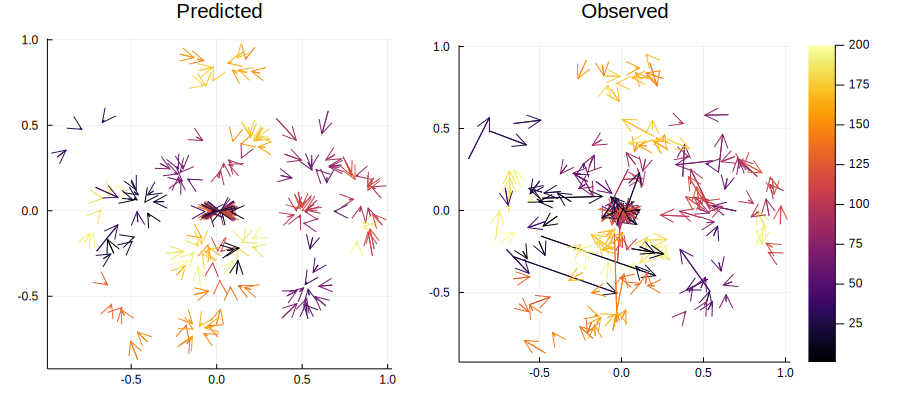

In [106]:

@_ recalled_known |>
    @where(_, :subjid1 .== 1) |>
    @df _ arrowsmodresp(:x, :y, :x_mod, :y_mod, :x_resp, :y_resp, 
                        linez=:respnr,size=(900, 400))


## Finding a good prior

Let's use these results to find a good prior for the cluster parameters.  Start by fitting the actual distributions, then we'll see about finding a prior that fits _behavior_ well (if possible).

In [107]:
suffstats_true = @_ recall |>
    @where(_, :subjid1 .== 1) |>
    @by(_, :block, suffstats = suffstats(MvNormal, hcat(:x, :y)')) |>
    @with(_, :suffstats)

Particles.marginal_log_lhood.(prior, suffstats_true)

25-element Array{Float64,1}:
 26.769300995357483   
 -0.5641518910931822  
 -2.2817124012314194  
  0.49434045046318253 
  0.022226430444071354
  3.1481799748259505  
 -2.7107835318605433  
 -3.43541705996494    
 -2.1677131691309866  
  0.9882107998506235  
  4.528653782064053   
  2.967998353939091   
 -2.698737697618891   
 -1.9298243361959138  
  0.4667736543062322  
  3.7866752943469226  
  8.719393095308156   
 -2.3677889764551265  
  3.733108267602244   
 -2.9336687287566994  
  3.7778836990926052  
  4.0420172082741885  
  1.1541145667426385  
 -1.1966682742005705  
  6.4392483569333905  

MethodError: MethodError: Cannot `convert` an object of type Diagonal{Int64,Array{Int64,1}} to an object of type Cholesky
Closest candidates are:
  convert(::Type{T<:Factorization}, !Matched::T<:Factorization) where T<:Factorization at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/LinearAlgebra/src/factorization.jl:43
  convert(::Type{T<:Factorization}, !Matched::Factorization) where T<:Factorization at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/LinearAlgebra/src/factorization.jl:44
  convert(::Type{S}, !Matched::T<:(Union{CategoricalString{R}, CategoricalValue{T,R} where T} where R)) where {S, T<:(Union{CategoricalString{R}, CategoricalValue{T,R} where T} where R)} at /home/dave/.julia/packages/CategoricalArrays/ucKV2/src/value.jl:91
  ...

In [135]:
pack(x::Vector{Float64}) = NormalInverseWishart(x[1:2], exp(x[3]), cholesky!(exp(x[4])^2*eye(2)), exp(x[5])-1+2)
unpack(d::NormalInverseWishart) = [d.mu..., log(d.kappa), log(d.Lamchol.U[1]), log(d.nu+1-2)]

unpack(prior)

5-element Array{Float64,1}:
  0.0               
  0.0               
 -2.3025850929940455
 -0.6019864021629681
  0.6931471805599453

In [136]:
prior

NormalInverseWishart{Float64}(
dim: 2
zeromean: true
mu: [0.0, 0.0]
kappa: 0.1
Lamchol: Cholesky{Float64,Array{Float64,2}}([0.547723 0.0; 0.0 0.547723], 'U', 0)
nu: 3.0
)


In [137]:
pack(unpack(prior))

NormalInverseWishart{Float64}(
dim: 2
zeromean: true
mu: [0.0, 0.0]
kappa: 0.10000000000000002
Lamchol: Cholesky{Float64,Array{Float64,2}}([0.547723 0.0; 0.0 0.547723], 'U', 0)
nu: 3.0
)


In [139]:
using Optim

res = optimize(x -> -sum(Particles.marginal_log_lhood.(pack(x), suffstats_true)), unpack(prior))

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.0,0.0, ...]
 * Minimizer: [0.043345754234714234,0.020487860197673582, ...]
 * Minimum: -3.332468e+02
 * Iterations: 208
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 357

In [141]:
@show prior_optimized = pack(Optim.minimizer(res))
@save "prior_empirical.jld2" prior_optimized

prior_optimized = pack(Optim.minimizer(res)) = NormalInverseWishart{Float64}(
dim: 2
zeromean: false
mu: [0.0433458, 0.0204879]
kappa: 0.025566395614905986
Lamchol: Cholesky{Float64,Array{Float64,2}}([0.0723856 0.0; 0.0 0.0723856], 'U', 0)
nu: 2.784457899850737
)



In [142]:
@time recalled_known_opt = by(recall, :subjid1, d->model_recall(d, KnownFilter(prior_optimized), Matrix(0.05I, 2,2)))

  0.068366 seconds (312.41 k allocations: 16.787 MiB, 19.99% gc time)


1600×28 DataFrame. Omitted printing of 21 columns
│ Row  │ subjid1 │ subjid1_1 │ block │ rep   │ respnr │ line  │ rad     │
│      │ Int64   │ Int64     │ Int64 │ Int64 │ Int64  │ Int64 │ Float64 │
├──────┼─────────┼───────────┼───────┼───────┼────────┼───────┼─────────┤
│ 1    │ 1       │ 1         │ 1     │ 1     │ 1      │ 1     │ 0.0     │
│ 2    │ 1       │ 1         │ 1     │ 2     │ 2      │ 1     │ 0.0     │
│ 3    │ 1       │ 1         │ 1     │ 3     │ 3      │ 1     │ 0.0     │
│ 4    │ 1       │ 1         │ 1     │ 4     │ 4      │ 1     │ 0.0     │
│ 5    │ 1       │ 1         │ 1     │ 5     │ 5      │ 1     │ 0.0     │
│ 6    │ 1       │ 1         │ 1     │ 6     │ 6      │ 1     │ 0.0     │
│ 7    │ 1       │ 1         │ 1     │ 7     │ 7      │ 1     │ 0.0     │
│ 8    │ 1       │ 1         │ 1     │ 8     │ 8      │ 1     │ 0.0     │
│ 9    │ 1       │ 1         │ 1     │ 9     │ 9      │ 1     │ 0.0     │
│ 10   │ 1       │ 1         │ 1     │ 10    │ 10     │ 1     │ 0.0     │
⋮
│ 1590 │ 8       │ 8         │ 23    │ 11    │ 190    │ 17    │ 0.3     │
│ 1591 │ 8       │ 8         │ 23    │ 12    │ 191    │ 17    │ 0.3     │
│ 1592 │ 8       │ 8         │ 24    │ 1     │ 192    │ 23    │ 0.0     │
│ 1593 │ 8       │ 8         │ 24    │ 2     │ 193    │ 23    │ 0.0     │
│ 1594 │ 8       │ 8         │ 24    │ 3     │ 194    │ 23    │ 0.0     │
│ 1595 │ 8       │ 8         │ 24    │ 4     │ 195    │ 23    │ 0.0     │
│ 1596 │ 8       │ 8         │ 24    │ 5     │ 196    │ 23    │ 0.0     │
│ 1597 │ 8       │ 8         │ 24    │ 6     │ 197    │ 23    │ 0.0     │
│ 1598 │ 8       │ 8         │ 25    │ 1     │ 198    │ 4     │ 0.0     │
│ 1599 │ 8       │ 8         │ 25    │ 2     │ 199    │ 4     │ 0.0     │
│ 1600 │ 8       │ 8         │ 25    │ 3     │ 200    │ 4     │ 0.0     │

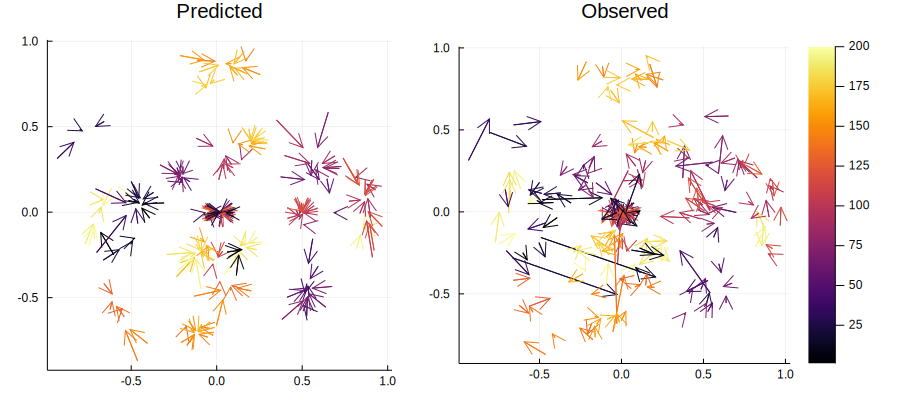

In [143]:
@_ recalled_known_opt |>
    @where(_, :subjid1 .== 1) |>
    @df _ arrowsmodresp(:x, :y, :x_mod, :y_mod, :x_resp, :y_resp, 
                        linez=:respnr,size=(900, 400))

### Optimizing the memory uncertainty based on the prior

In [144]:
function recall_mse(d, prior, σ) 
    recalled = by(d, :subjid1, d->model_recall(d, KnownFilter(prior), Matrix(σ*I, 2,2), add=false))
    mean((d[:x_resp] .- recalled[:x_mod]).^2 .+ (d[:y_resp] .- recalled[:y_mod]).^2)
end


recall_mse (generic function with 1 method)

In [145]:
recall_mse(recall, prior_optimized, 0.05)

0.0314442520804768

In [146]:
σ_res = optimize(logσ -> recall_mse(recall, prior_optimized, exp(logσ)), -10., 10.)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-10.000000, 10.000000]
 * Minimizer: -6.644895e+00
 * Minimum: 2.781350e-02
 * Iterations: 14
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 15

In [147]:
σ_optimzied = sqrt(exp(Optim.minimizer(σ_res)))

0.0360644564277863

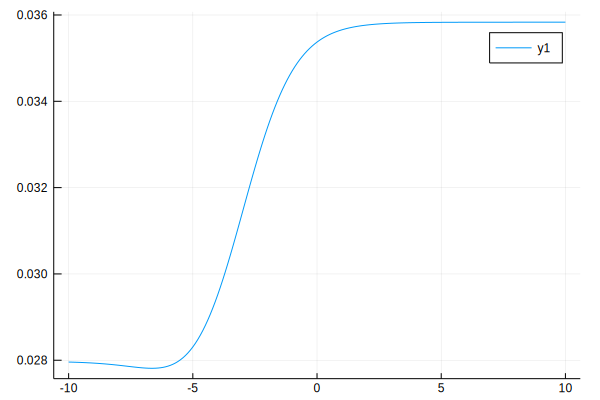

In [149]:
plot(x -> recall_mse(recall, prior_optimized, exp(x)), -10:.1:10)

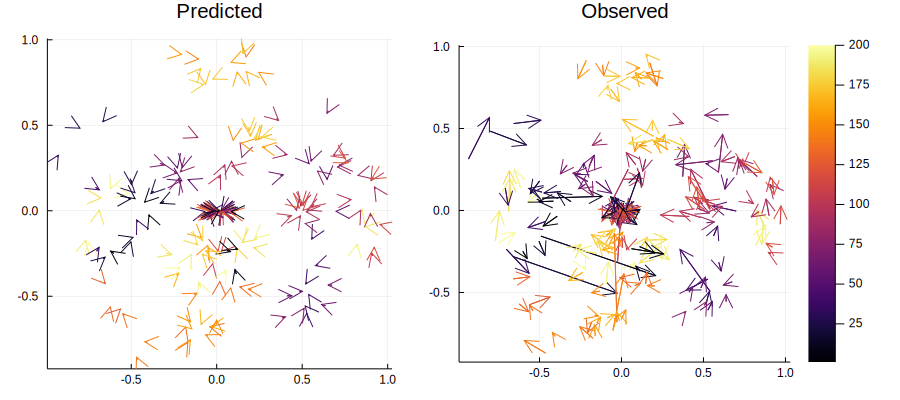

In [150]:
recalled_known_optimized = @_ recall |>
    @where(_, :subjid1 .== 1) |>
    model_recall(_, KnownFilter(prior_optimized), Matrix(σ_optimzied^2 * I, 2, 2))


@_ recalled_known_optimized |>
    @df _ arrowsmodresp(:x, :y, :x_mod, :y_mod, :x_resp, :y_resp, 
                        linez=:respnr,size=(900, 400))


Okay sensory certainty that high, that's just ridiculous.  You'll never get any reliable bias.  What about if we optimize them _together_??

### Jointly optimized prior and sensory uncertainty

In [92]:
σ_prior_res = optimize(x -> recall_mse(recall, pack(x[2:end]), exp(x[1])), unshift!(unpack(prior_optimized), -2))

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [-2.0,0.043345754234714234, ...]
 * Minimizer: [1.2085955727445885,-0.30451395781986756, ...]
 * Minimum: 2.694754e-02
 * Iterations: 308
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 695

In [93]:
σ_optimized_again = exp(Optim.minimizer(σ_prior_res)[1])

3.348778232987918

In [94]:
prior_optimized_again = pack(Optim.minimizer(σ_prior_res)[2:end])

ConjugatePriors.NormalInverseWishart{Float64}(
dim: 2
zeromean: false
mu: [-0.304514, 0.236468]
kappa: 1.3487572687865894
Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[93.8492 0.0; 0.0 93.8492]
nu: 510.5129725741536
)


okay this is just bonkers.  high confidence in large covariance, plus large sensory uncertainty means that there's not any adapting to the cluster variance, and not much to the mean (kappa = 1.3).  And you can see that much of the bias is towards the center:

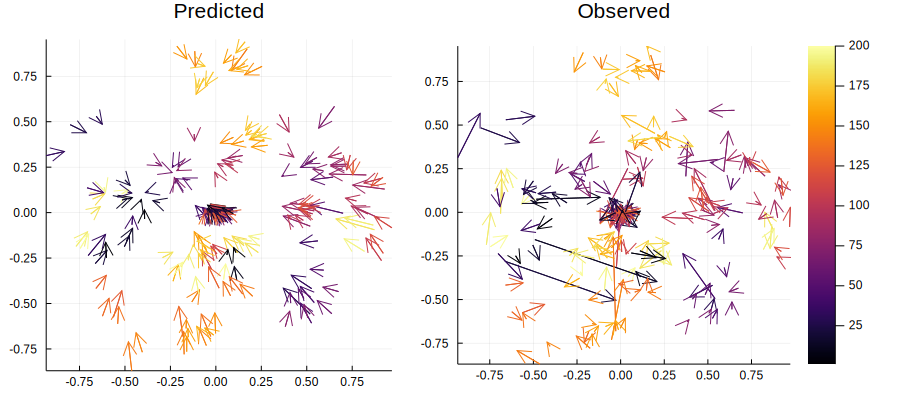

In [95]:
recalled_known_optimized_again = @_ recall |>
    @where(_, :subjid1 .== 1) |>
    model_recall(_, KnownFilter(prior_optimized_again), Matrix(σ_optimized_again^2 * I, 2, 2))


@_ recalled_known_optimized_again |>
    @df _ arrowsmodresp(:x, :y, :x_mod, :y_mod, :x_resp, :y_resp, 
                        linez=:respnr,size=(900, 400))


In [96]:
recalled_inferred_opt_again = by(recall, :subjid1) do d
    model_recall(d, ChenLiuParticles(100, prior_optimized_again, StickyCRP(α, 0.9)), Matrix(σ_optimized_again*I,2,2))
end


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /home/dave/.julia/v0.6/DataFrames/src/other/index.jl:190
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#76(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /home/dave/.julia/v0.6/DataFrames/src/dataframe/dataframe.jl:840
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] hcat!(::DataFrames.DataFrame, ::DataFrames.DataFrame) at /home/dave/.julia/v0.6/DataFrames/src/dataframe/dataframe.jl:849
 [7] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /home/dave/.julia/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [8] (::DataFrames.#kw##by)(::Array{Any,1}, ::DataFrames.#by, ::DataFrames.DataFrame, ::Symbol, ::Function) at ./<

1600×27 DataFrames.DataFrame. Omitted printing of 19 columns
│ Row  │ subjid1 │ subjid1_1 │ block │ rep  │ respnr │ line │ rad │ var  │
├──────┼─────────┼───────────┼───────┼──────┼────────┼──────┼─────┼──────┤
│ 1    │ 1.0     │ 1.0       │ 1.0   │ 1.0  │ 1.0    │ 1.0  │ 0.0 │ 0.01 │
│ 2    │ 1.0     │ 1.0       │ 1.0   │ 2.0  │ 2.0    │ 1.0  │ 0.0 │ 0.01 │
│ 3    │ 1.0     │ 1.0       │ 1.0   │ 3.0  │ 3.0    │ 1.0  │ 0.0 │ 0.01 │
│ 4    │ 1.0     │ 1.0       │ 1.0   │ 4.0  │ 4.0    │ 1.0  │ 0.0 │ 0.01 │
│ 5    │ 1.0     │ 1.0       │ 1.0   │ 5.0  │ 5.0    │ 1.0  │ 0.0 │ 0.01 │
│ 6    │ 1.0     │ 1.0       │ 1.0   │ 6.0  │ 6.0    │ 1.0  │ 0.0 │ 0.01 │
│ 7    │ 1.0     │ 1.0       │ 1.0   │ 7.0  │ 7.0    │ 1.0  │ 0.0 │ 0.01 │
│ 8    │ 1.0     │ 1.0       │ 1.0   │ 8.0  │ 8.0    │ 1.0  │ 0.0 │ 0.01 │
│ 9    │ 1.0     │ 1.0       │ 1.0   │ 9.0  │ 9.0    │ 1.0  │ 0.0 │ 0.01 │
│ 10   │ 1.0     │ 1.0       │ 1.0   │ 10.0 │ 10.0   │ 1.0  │ 0.0 │ 0.01 │
│ 11   │ 1.0     │ 1.0       │ 1.0   │ 11.0 │ 11.0   │ 1.0  │ 0.0 │ 0.01 │
⋮
│ 1589 │ 8.0     │ 8.0       │ 23.0  │ 10.0 │ 189.0  │ 17.0 │ 0.3 │ 0.04 │
│ 1590 │ 8.0     │ 8.0       │ 23.0  │ 11.0 │ 190.0  │ 17.0 │ 0.3 │ 0.04 │
│ 1591 │ 8.0     │ 8.0       │ 23.0  │ 12.0 │ 191.0  │ 17.0 │ 0.3 │ 0.04 │
│ 1592 │ 8.0     │ 8.0       │ 24.0  │ 1.0  │ 192.0  │ 23.0 │ 0.0 │ 0.01 │
│ 1593 │ 8.0     │ 8.0       │ 24.0  │ 2.0  │ 193.0  │ 23.0 │ 0.0 │ 0.01 │
│ 1594 │ 8.0     │ 8.0       │ 24.0  │ 3.0  │ 194.0  │ 23.0 │ 0.0 │ 0.01 │
│ 1595 │ 8.0     │ 8.0       │ 24.0  │ 4.0  │ 195.0  │ 23.0 │ 0.0 │ 0.01 │
│ 1596 │ 8.0     │ 8.0       │ 24.0  │ 5.0  │ 196.0  │ 23.0 │ 0.0 │ 0.01 │
│ 1597 │ 8.0     │ 8.0       │ 24.0  │ 6.0  │ 197.0  │ 23.0 │ 0.0 │ 0.01 │
│ 1598 │ 8.0     │ 8.0       │ 25.0  │ 1.0  │ 198.0  │ 4.0  │ 0.0 │ 0.01 │
│ 1599 │ 8.0     │ 8.0       │ 25.0  │ 2.0  │ 199.0  │ 4.0  │ 0.0 │ 0.01 │
│ 1600 │ 8.0     │ 8.0       │ 25.0  │ 3.0  │ 200.0  │ 4.0  │ 0.0 │ 0.01 │

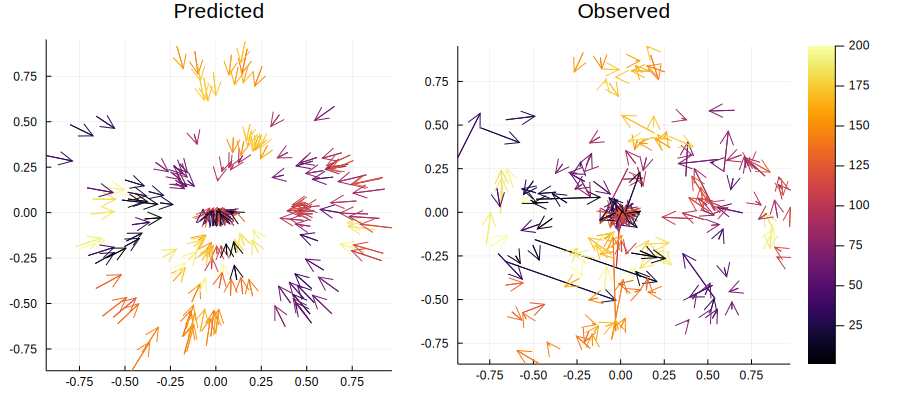

In [97]:
@_ recalled_inferred_opt_again |>
    @where(_, :subjid1 .== 1) |>
    @df _ arrowsmodresp(:x, :y, :x_mod, :y_mod, :x_resp, :y_resp, 
                        linez=:respnr,size=(900, 400))


### Conclusion: parameter estimation

Let's use the "empirical Bayes" prior (estimated from the actual cluster distributions) and treat the sensory uncertainy as a free parameter.

# General modeling considerations

## Radial bias as a dependent measure

I'm a little worried abuot using the radial bias as a dependent measure, since there are weird things that happen to it with noisy responses and target values near the extremes of teh range.  At radius 0, you can't get a negative bias, so the expected radial bias is always positive when you're trying to hit 0 (and just off by a little).  At radius 1, the responses are cut off at the edge of the arena so it's possible that there's a _negative_ bias on average introduced there just because the distribution is truncated.

**So we shouldn't expect the predicted bias to exactly match the sign of the observed bias because it's the predicted _expected_ bias**

# Modeling random data

The 2017 dataset also has a condition with _no_ structure.  What does the model do with that?

In [98]:
@load "data/dots2017_rand.jld2"

2-element Array{Symbol,1}:
 :recall_2017_rand
 :pred_2017_rand  

In [99]:
recall_2017_rand

2576×11 DataFrames.DataFrame. Omitted printing of 5 columns
│ Row  │ angle_resp │ angles  │ correct │ rad_resp  │ rads      │ x_coord │
├──────┼────────────┼─────────┼─────────┼───────────┼───────────┼─────────┤
│ 1    │ 321.236    │ 307.618 │ 0.0     │ 0.512801  │ 0.481337  │ 309.367 │
│ 2    │ 231.789    │ 230.988 │ 1.0     │ 0.0713953 │ 0.183304  │ 428.785 │
│ 3    │ 34.7367    │ 21.7675 │ 1.0     │ 0.416846  │ 0.382375  │ 570.9   │
│ 4    │ 35.0636    │ 71.7275 │ 1.0     │ 0.234773  │ 0.0210956 │ 510.016 │
│ 5    │ 183.013    │ 175.084 │ 1.0     │ 0.0227093 │ 0.332362  │ 514.242 │
│ 6    │ 143.292    │ 157.826 │ 0.0     │ 0.421333  │ 0.631164  │ 619.11  │
│ 7    │ 85.2175    │ 105.53  │ 1.0     │ 0.300634  │ 0.332405  │ 660.134 │
│ 8    │ 310.411    │ 301.331 │ 1.0     │ 0.506326  │ 0.421707  │ 319.894 │
│ 9    │ 53.0272    │ 9.729   │ 0.0     │ 0.132964  │ 0.0313097 │ 502.645 │
│ 10   │ 111.721    │ 116.867 │ 0.0     │ 0.15803   │ 0.183733  │ 581.95  │
│ 11   │ 281.646    │ 272.824 │ 0.0     │ 0.478934  │ 0.481979  │ 259.303 │
⋮
│ 2565 │ 2.70063    │ 274.047 │ 0.0     │ 0.123068  │ 0.0441417 │ 477.984 │
│ 2566 │ 326.029    │ 329.051 │ 0.0     │ 0.45868   │ 0.462595  │ 381.048 │
│ 2567 │ 46.0975    │ 39.92   │ 1.0     │ 0.214073  │ 0.203279  │ 565.224 │
│ 2568 │ 233.742    │ 269.904 │ 1.0     │ 0.80397   │ 0.812635  │ 93.6831 │
│ 2569 │ 324.502    │ 325.764 │ 1.0     │ 0.968652  │ 0.859238  │ 258.298 │
│ 2570 │ 23.7204    │ 35.8434 │ 0.0     │ 0.0836052 │ 0.0844531 │ 524.727 │
│ 2571 │ 123.988    │ 131.295 │ 1.0     │ 0.742702  │ 0.680889  │ 755.783 │
│ 2572 │ 0.576231   │ 351.653 │ 0.0     │ 0.807213  │ 0.74981   │ 445.579 │
│ 2573 │ 77.5315    │ 81.7679 │ 1.0     │ 0.956133  │ 0.909429  │ 950.029 │
│ 2574 │ 321.319    │ 310.721 │ 1.0     │ 0.499165  │ 0.374191  │ 358.202 │
│ 2575 │ 134.845    │ 134.843 │ 1.0     │ 0.907802  │ 0.884133  │ 813.445 │
│ 2576 │ 325.491    │ 183.482 │ 1.0     │ 0.0225179 │ 0.0424509 │ 498.711 │

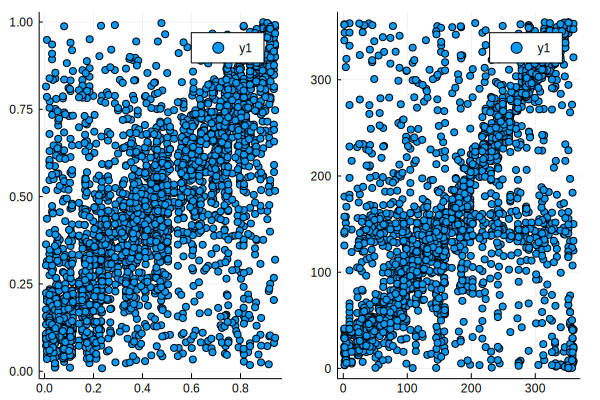

In [100]:
@df recall_2017_rand plot(scatter(:rads, :rad_resp), scatter(:angles, :angle_resp))


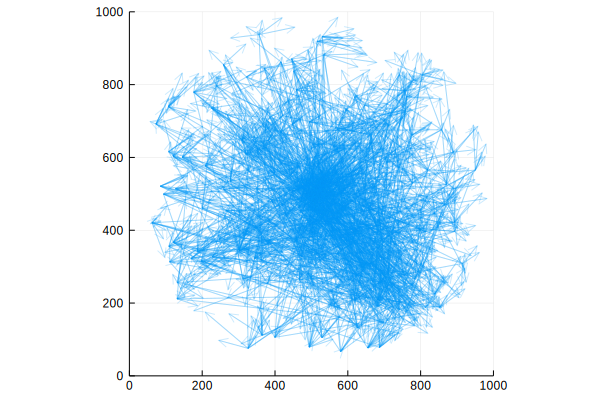

In [101]:
@_ recall_2017_rand |>
    #@where(_, :subnum .== last(:subnum)) |>
#     @transform(_, angle_resp = deg2rad.(:angle_resp), angles = deg2rad.(:angles)) |>
#     @transform(_, 
#                x_resp = sin.(:angle_resp) .* (:rad_resp),
#                y_resp = cos.(:angle_resp) .* (:rad_resp),
#                x = sin.(:angles) .* :rads,
#                y = cos.(:angles) .* :rads) |>
    @df _ arrows(:x_coord, :x, :y_coord, :y, xlims=(0, 1000), ylims=(0,1000), linealpha=0.2)

In [102]:
@where(recall_2017_rand, :subnum .== first(:subnum), :rad_resp .< 0)

0×11 DataFrames.DataFrame

Well this is bad news: lots of uniform responses.  Those are going to screw up the mean bias...

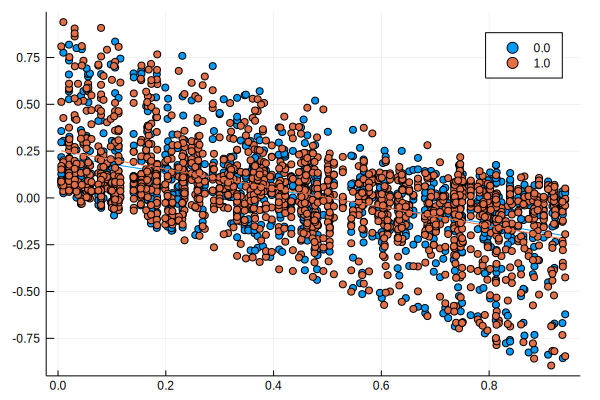

In [103]:
@_ recall_2017_rand |>
    @transform(_, rad_bias = abs.(:rad_resp) .- :rads) |>
    @df _ scatter(:rads, :rad_bias, group=:correct, smooth=true)

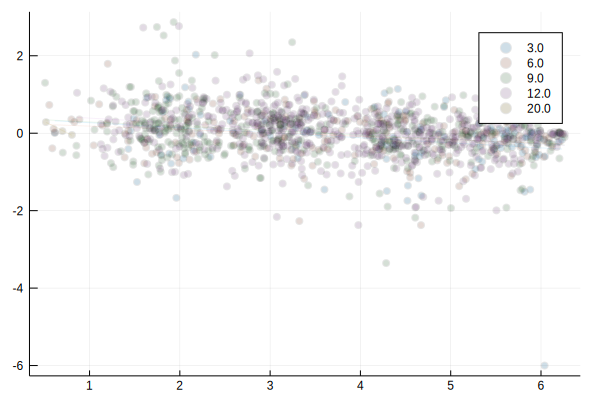

In [104]:
@df @where(recall, :rho.>0.5) scatter(:rho, :new_rho_bias, group=:rep_number, alpha=0.1, smooth=true)

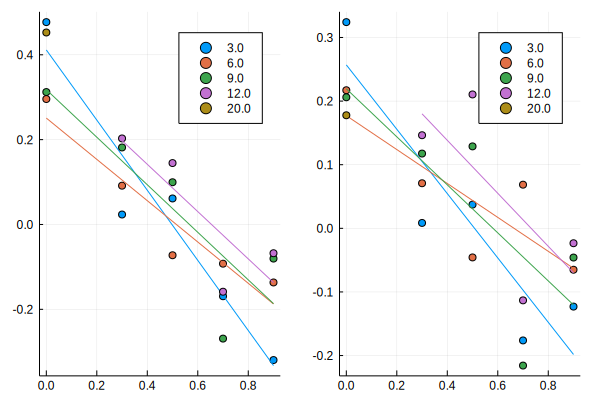

In [105]:
@_ recall |> 
    @by(_, [:rep_number, :rad], mean_rho_bias = mean(:new_rho_bias), med_rho_bias = median(:new_rho_bias)) |>
    @df _ plot(scatter(:rad, :mean_rho_bias, group=:rep_number, smooth=true),
               scatter(:rad, :med_rho_bias, group=:rep_number, smooth=true))

# Experiments

An `Experiment` is a Dict of parameter settings and a random seed.  It can be `run` through a function to produce a `Result`, which has the runner, the experiment, and the outcome of the function.

In [5]:
Revise.track("experiments.jl")
include("experiments.jl")

# include this here because of the JLD file...
function runner(params::Dict, data)
    res = DataFrames.by(data, :subjid1) do d
        DotLearning.model_recall(
            d,
            Particles.ChenLiuParticles(params[:n],
                                       params[:prior],
                                       Particles.StickyCRP(params[:α], params[:ρ])),
            Matrix(params[:Sσ]*I, 2,2),
            add=false
        )
    end
    println("$params => mse=$(mse(data, res)), cosine=$(cosinedist(data, res))")
    return res
end


runner (generic function with 1 method)

In [6]:
@load "results/run2.jld2"

2-element Array{Symbol,1}:
 :results
 :expts  

Summary of results: (sqrt of) mean-squared error `mse` measures how far off in Euclidean distance the predicted recall response is from the actual responses.  Cosine-similarity `cos` measures whether the deviations from the studied item align in direction (0 is orthogonal, +1 is perfect alignment, -1 is perfect anti-alignment).

In [7]:
results_df = @_ results |>
    vec |>
    summarize.(_, mse=mse, cos=cosinesim) |>
    dictofarrays |>
    DataFrame |>
    @select(_, :batch, :n, :α, :ρ, Sσ=sqrt.(:Sσ), :iter, :cos, :mse)

360×8 DataFrames.DataFrame
│ Row │ batch │ n   │ α    │ ρ   │ Sσ   │ iter │ cos       │ mse      │
├─────┼───────┼─────┼──────┼─────┼──────┼──────┼───────────┼──────────┤
│ 1   │ run2  │ 100 │ 0.01 │ 0.1 │ 0.01 │ 1    │ 0.0920803 │ 0.118962 │
│ 2   │ run2  │ 100 │ 0.1  │ 0.1 │ 0.01 │ 1    │ 0.0831909 │ 0.118961 │
│ 3   │ run2  │ 100 │ 1.0  │ 0.1 │ 0.01 │ 1    │ 0.0841788 │ 0.118968 │
│ 4   │ run2  │ 100 │ 10.0 │ 0.1 │ 0.01 │ 1    │ 0.0728853 │ 0.118996 │
│ 5   │ run2  │ 100 │ 0.01 │ 0.5 │ 0.01 │ 1    │ 0.111831  │ 0.118928 │
│ 6   │ run2  │ 100 │ 0.1  │ 0.5 │ 0.01 │ 1    │ 0.0931207 │ 0.11895  │
│ 7   │ run2  │ 100 │ 1.0  │ 0.5 │ 0.01 │ 1    │ 0.0843713 │ 0.118967 │
│ 8   │ run2  │ 100 │ 10.0 │ 0.5 │ 0.01 │ 1    │ 0.0876474 │ 0.118971 │
│ 9   │ run2  │ 100 │ 0.01 │ 0.9 │ 0.01 │ 1    │ 0.107288  │ 0.118936 │
│ 10  │ run2  │ 100 │ 0.1  │ 0.9 │ 0.01 │ 1    │ 0.104892  │ 0.11894  │
│ 11  │ run2  │ 100 │ 1.0  │ 0.9 │ 0.01 │ 1    │ 0.101737  │ 0.118943 │
⋮
│ 349 │ run2  │ 100 │ 0.01 │ 0.1 │ 1.0  │ 10   │ 0.0919229 │ 0.207123 │
│ 350 │ run2  │ 100 │ 0.1  │ 0.1 │ 1.0  │ 10   │ 0.0956019 │ 0.166871 │
│ 351 │ run2  │ 100 │ 1.0  │ 0.1 │ 1.0  │ 10   │ 0.0815899 │ 0.148903 │
│ 352 │ run2  │ 100 │ 10.0 │ 0.1 │ 1.0  │ 10   │ 0.0801373 │ 0.129811 │
│ 353 │ run2  │ 100 │ 0.01 │ 0.5 │ 1.0  │ 10   │ 0.103766  │ 0.185744 │
│ 354 │ run2  │ 100 │ 0.1  │ 0.5 │ 1.0  │ 10   │ 0.0999445 │ 0.159585 │
│ 355 │ run2  │ 100 │ 1.0  │ 0.5 │ 1.0  │ 10   │ 0.102149  │ 0.146218 │
│ 356 │ run2  │ 100 │ 10.0 │ 0.5 │ 1.0  │ 10   │ 0.0991363 │ 0.136993 │
│ 357 │ run2  │ 100 │ 0.01 │ 0.9 │ 1.0  │ 10   │ 0.103126  │ 0.190547 │
│ 358 │ run2  │ 100 │ 0.1  │ 0.9 │ 1.0  │ 10   │ 0.109442  │ 0.161483 │
│ 359 │ run2  │ 100 │ 1.0  │ 0.9 │ 1.0  │ 10   │ 0.103322  │ 0.148759 │
│ 360 │ run2  │ 100 │ 10.0 │ 0.9 │ 1.0  │ 10   │ 0.105309  │ 0.140845 │

In [8]:
results_summary = @by(results_df, [:α, :ρ, :Sσ, :batch, :n], mse=mean(:mse), cos=mean(:cos))

36×7 DataFrames.DataFrame
│ Row │ α    │ ρ   │ Sσ   │ batch │ n   │ mse      │ cos       │
├─────┼──────┼─────┼──────┼───────┼─────┼──────────┼───────────┤
│ 1   │ 0.01 │ 0.1 │ 0.01 │ run2  │ 100 │ 0.118963 │ 0.0897934 │
│ 2   │ 0.1  │ 0.1 │ 0.01 │ run2  │ 100 │ 0.118964 │ 0.0863524 │
│ 3   │ 1.0  │ 0.1 │ 0.01 │ run2  │ 100 │ 0.118975 │ 0.0808561 │
│ 4   │ 10.0 │ 0.1 │ 0.01 │ run2  │ 100 │ 0.118995 │ 0.0756688 │
│ 5   │ 0.01 │ 0.5 │ 0.01 │ run2  │ 100 │ 0.118936 │ 0.105113  │
│ 6   │ 0.1  │ 0.5 │ 0.01 │ run2  │ 100 │ 0.118944 │ 0.0965734 │
│ 7   │ 1.0  │ 0.5 │ 0.01 │ run2  │ 100 │ 0.118959 │ 0.0915619 │
│ 8   │ 10.0 │ 0.5 │ 0.01 │ run2  │ 100 │ 0.118971 │ 0.0881195 │
│ 9   │ 0.01 │ 0.9 │ 0.01 │ run2  │ 100 │ 0.118933 │ 0.108595  │
│ 10  │ 0.1  │ 0.9 │ 0.01 │ run2  │ 100 │ 0.118933 │ 0.105004  │
│ 11  │ 1.0  │ 0.9 │ 0.01 │ run2  │ 100 │ 0.118944 │ 0.100817  │
⋮
│ 25  │ 0.01 │ 0.1 │ 1.0  │ run2  │ 100 │ 0.198971 │ 0.0951195 │
│ 26  │ 0.1  │ 0.1 │ 1.0  │ run2  │ 100 │ 0.1659   │ 0.0889403 │
│ 27  │ 1.0  │ 0.1 │ 1.0  │ run2  │ 100 │ 0.148267 │ 0.0824187 │
│ 28  │ 10.0 │ 0.1 │ 1.0  │ run2  │ 100 │ 0.130425 │ 0.088568  │
│ 29  │ 0.01 │ 0.5 │ 1.0  │ run2  │ 100 │ 0.185313 │ 0.10585   │
│ 30  │ 0.1  │ 0.5 │ 1.0  │ run2  │ 100 │ 0.160338 │ 0.0968882 │
│ 31  │ 1.0  │ 0.5 │ 1.0  │ run2  │ 100 │ 0.146444 │ 0.0980806 │
│ 32  │ 10.0 │ 0.5 │ 1.0  │ run2  │ 100 │ 0.136532 │ 0.0957898 │
│ 33  │ 0.01 │ 0.9 │ 1.0  │ run2  │ 100 │ 0.189741 │ 0.109994  │
│ 34  │ 0.1  │ 0.9 │ 1.0  │ run2  │ 100 │ 0.161986 │ 0.103157  │
│ 35  │ 1.0  │ 0.9 │ 1.0  │ run2  │ 100 │ 0.148537 │ 0.099414  │
│ 36  │ 10.0 │ 0.9 │ 1.0  │ run2  │ 100 │ 0.140868 │ 0.0985356 │

In [9]:
results[1].experiment

Experiment(α=0.01, ρ=0.1, Sσ=0.0001, batch=run2, n=100, iter=1, prior=ConjugatePriors.NormalInverseWishart{Float64}(
dim: 2
zeromean: false
mu: [0.0433458, 0.0204879]
kappa: 0.025566395614905986
Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.0723856 0.0; 0.0 0.0723856]
nu: 2.784457899850737
)
)

In [12]:
@_ hcat(results[1].experiment.data, results[1].result, makeunique=true) |>
    @where(_, :subjid1 .== first(:subjid1)) |>
    @df _ arrowsmodresp(:x, :y, :x_mod, :y_mod, :x_resp, :y_resp, linez = :respnr)

LoadError: [91mUndefVarError: arrowsmodresp not defined[39m

In [112]:
results[last(findmin(results_df[:cos]))]

Result of Experiment(α=10.0, ρ=0.1, Sσ=0.0001, batch=run2, n=100, iter=9, prior=ConjugatePriors.NormalInverseWishart{Float64}(
dim: 2
zeromean: false
mu: [0.0433458, 0.0204879]
kappa: 0.025566395614905986
Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.0723856 0.0; 0.0 0.0723856]
nu: 2.784457899850737
)
): 1600×4 DataFrames.DataFrame
│ Row  │ subjid1 │ x_mod       │ y_mod        │ rho_mod     │
├──────┼─────────┼─────────────┼──────────────┼─────────────┤
│ 1    │ 1.0     │ 0.0318544   │ 0.00563721   │ 0.0323494   │
│ 2    │ 1.0     │ 0.0279551   │ 0.000488686  │ 0.0279594   │
│ 3    │ 1.0     │ -0.0146621  │ -0.000414962 │ 0.0146679   │
│ 4    │ 1.0     │ 0.0490325   │ -0.00368377  │ 0.0491707   │
│ 5    │ 1.0     │ -0.029161   │ -0.000896258 │ 0.0291748   │
│ 6    │ 1.0     │ 0.00875091  │ -0.000389911 │ 0.0087596   │
│ 7    │ 1.0     │ 0.030268    │ 0.00265447   │ 0.0303841   │
│ 8    │ 1.0     │ 0.0342596   │ 0.00376283   │ 0.0344656   │
│ 9    │ 1.0     │ -

There's a floor for the MSE, which is the mean deviation of the responses themselves from the presented locations:

In [13]:
mse_observed = @with(recall, mean(@. sqrt((:x-:x_resp)^2 + (:y-:y_resp)^2)))

0.11907117245107529

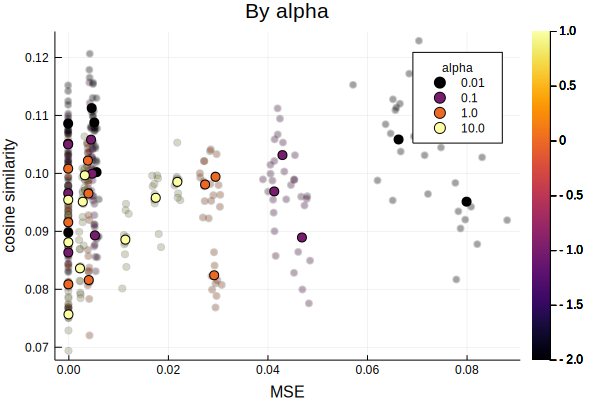

In [18]:
@df results_df scatter(:mse .- mse_observed, :cos, markerz=log10.(:α), markeralpha=0.2,
                       xlabel="MSE", ylabel="cosine similarity", title="By alpha", label="")
@df results_summary scatter!(:mse .- mse_observed, :cos, markerz=log10.(:α), markersize=5, markeralpha=1,
                             group=:α, legend_title="alpha")

In [115]:
@by(results_df, [:α, :ρ, :Sσ], relative_mse = mean(:mse) .- mse_observed)

36×4 DataFrames.DataFrame
│ Row │ α    │ ρ   │ Sσ   │ relative_mse │
├─────┼──────┼─────┼──────┼──────────────┤
│ 1   │ 0.01 │ 0.1 │ 0.01 │ -0.000107715 │
│ 2   │ 0.1  │ 0.1 │ 0.01 │ -0.000107649 │
│ 3   │ 1.0  │ 0.1 │ 0.01 │ -9.58164e-5  │
│ 4   │ 10.0 │ 0.1 │ 0.01 │ -7.58142e-5  │
│ 5   │ 0.01 │ 0.5 │ 0.01 │ -0.000134933 │
│ 6   │ 0.1  │ 0.5 │ 0.01 │ -0.00012724  │
│ 7   │ 1.0  │ 0.5 │ 0.01 │ -0.00011196  │
│ 8   │ 10.0 │ 0.5 │ 0.01 │ -0.000100665 │
│ 9   │ 0.01 │ 0.9 │ 0.01 │ -0.000138525 │
│ 10  │ 0.1  │ 0.9 │ 0.01 │ -0.000138278 │
│ 11  │ 1.0  │ 0.9 │ 0.01 │ -0.000127507 │
⋮
│ 25  │ 0.01 │ 0.1 │ 1.0  │ 0.0799003    │
│ 26  │ 0.1  │ 0.1 │ 1.0  │ 0.046829     │
│ 27  │ 1.0  │ 0.1 │ 1.0  │ 0.029196     │
│ 28  │ 10.0 │ 0.1 │ 1.0  │ 0.0113542    │
│ 29  │ 0.01 │ 0.5 │ 1.0  │ 0.0662422    │
│ 30  │ 0.1  │ 0.5 │ 1.0  │ 0.0412669    │
│ 31  │ 1.0  │ 0.5 │ 1.0  │ 0.0273733    │
│ 32  │ 10.0 │ 0.5 │ 1.0  │ 0.0174612    │
│ 33  │ 0.01 │ 0.9 │ 1.0  │ 0.0706697    │
│ 34  │ 0.1  │ 0.9 │ 1.0  │ 0.0429145    │
│ 35  │ 1.0  │ 0.9 │ 1.0  │ 0.0294657    │
│ 36  │ 10.0 │ 0.9 │ 1.0  │ 0.0217965    │

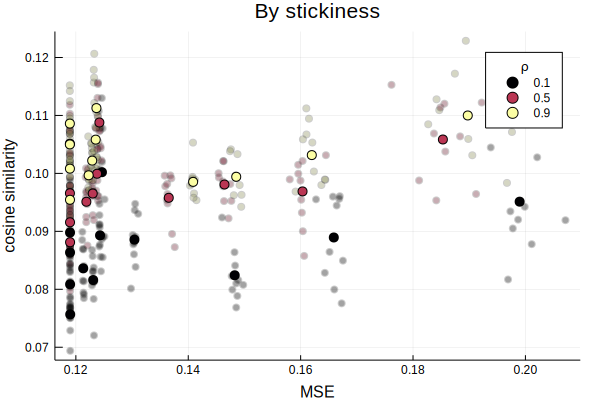

In [22]:
@df results_df scatter(:mse, :cos, markerz=:ρ, markeralpha=0.2, label="",
                       xlabel="MSE", ylabel="cosine similarity", title="By stickiness")
@df results_summary scatter!(:mse, :cos, markerz=:ρ, markersize=5, markeralpha=1, group=:ρ, legend_title="\\rho", colorbar=false)

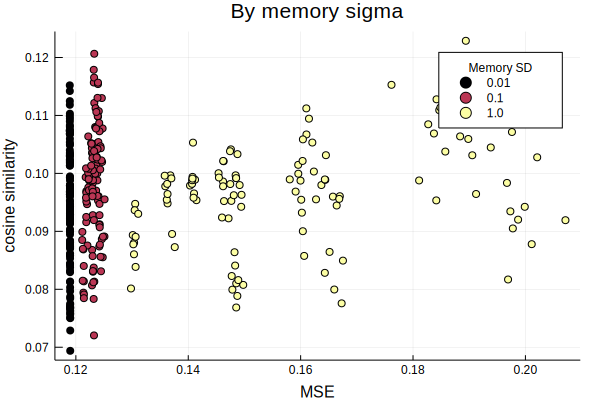

In [24]:
@df results_df scatter(:mse, :cos, markerz=log10.(:Sσ), 
                       xlabel="MSE", ylabel="cosine similarity", title="By memory sigma",
    group=:Sσ, colorbar=false, legend_title="Memory SD")

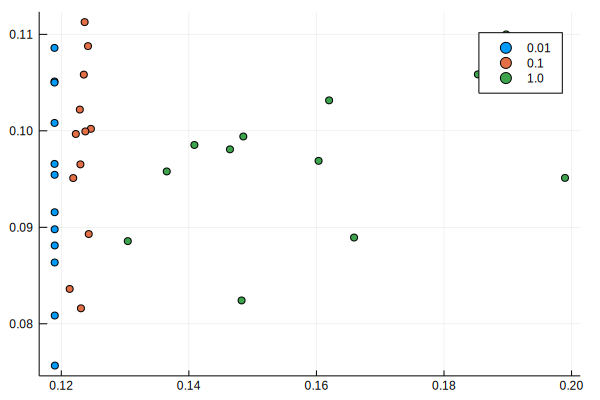

In [25]:
@_ results_df |>
    @by(_, [:Sσ, :n, :α, :ρ], cos = mean(:cos), mse=mean(:mse)) |>
    @df _ scatter(:mse, :cos, group=:Sσ)

In [119]:
sort(results_df, :mse)

360×8 DataFrames.DataFrame
│ Row │ batch │ n   │ α    │ ρ   │ Sσ   │ iter │ cos       │ mse      │
├─────┼───────┼─────┼──────┼─────┼──────┼──────┼───────────┼──────────┤
│ 1   │ run2  │ 100 │ 0.01 │ 0.9 │ 0.01 │ 2    │ 0.115198  │ 0.118919 │
│ 2   │ run2  │ 100 │ 0.1  │ 0.9 │ 0.01 │ 4    │ 0.107477  │ 0.118924 │
│ 3   │ run2  │ 100 │ 0.01 │ 0.9 │ 0.01 │ 10   │ 0.112477  │ 0.118927 │
│ 4   │ run2  │ 100 │ 0.01 │ 0.9 │ 0.01 │ 9    │ 0.114211  │ 0.118928 │
│ 5   │ run2  │ 100 │ 0.1  │ 0.9 │ 0.01 │ 3    │ 0.109887  │ 0.118928 │
│ 6   │ run2  │ 100 │ 0.01 │ 0.9 │ 0.01 │ 7    │ 0.10725   │ 0.118928 │
│ 7   │ run2  │ 100 │ 0.01 │ 0.5 │ 0.01 │ 1    │ 0.111831  │ 0.118928 │
│ 8   │ run2  │ 100 │ 0.1  │ 0.9 │ 0.01 │ 9    │ 0.102978  │ 0.11893  │
│ 9   │ run2  │ 100 │ 0.01 │ 0.5 │ 0.01 │ 9    │ 0.107403  │ 0.11893  │
│ 10  │ run2  │ 100 │ 0.1  │ 0.9 │ 0.01 │ 5    │ 0.106854  │ 0.118931 │
│ 11  │ run2  │ 100 │ 0.01 │ 0.9 │ 0.01 │ 3    │ 0.108975  │ 0.118931 │
⋮
│ 349 │ run2  │ 100 │ 0.01 │ 0.9 │ 1.0  │ 9    │ 0.113118  │ 0.194307 │
│ 350 │ run2  │ 100 │ 0.01 │ 0.1 │ 1.0  │ 7    │ 0.112345  │ 0.19497  │
│ 351 │ run2  │ 100 │ 0.01 │ 0.9 │ 1.0  │ 6    │ 0.098358  │ 0.196715 │
│ 352 │ run2  │ 100 │ 0.01 │ 0.1 │ 1.0  │ 5    │ 0.0816916 │ 0.19691  │
│ 353 │ run2  │ 100 │ 0.01 │ 0.1 │ 1.0  │ 2    │ 0.093448  │ 0.197323 │
│ 354 │ run2  │ 100 │ 0.01 │ 0.9 │ 1.0  │ 5    │ 0.107142  │ 0.197605 │
│ 355 │ run2  │ 100 │ 0.01 │ 0.1 │ 1.0  │ 3    │ 0.0905022 │ 0.19776  │
│ 356 │ run2  │ 100 │ 0.01 │ 0.1 │ 1.0  │ 6    │ 0.0920196 │ 0.198697 │
│ 357 │ run2  │ 100 │ 0.01 │ 0.1 │ 1.0  │ 9    │ 0.0942332 │ 0.199883 │
│ 358 │ run2  │ 100 │ 0.01 │ 0.1 │ 1.0  │ 1    │ 0.0877876 │ 0.20112  │
│ 359 │ run2  │ 100 │ 0.01 │ 0.1 │ 1.0  │ 8    │ 0.102773  │ 0.202095 │
│ 360 │ run2  │ 100 │ 0.01 │ 0.1 │ 1.0  │ 10   │ 0.0919229 │ 0.207123 │

# Modeling prediction

On the one hand, this is pretty straightforward: just run the stateprior forward $n$ trials and then use the predictive distribution from the component (prior for anythign $>K$).  But the question is, how do you _read out_ that predictive model?  Draw a sample?  It's easy to draw a single sample:

1. Sample particle
2. Sample state
3. Sample point

Alternatively, could treat it as a mixture model. Could either sample particle and state and use that as mixture component, but that's inefficient.  Not sure how to compute the distribution over states in the future though.  I guess it's just the probability of sticking for that long plus the CRP probability right?  I don't think so...there's some additional messiness from having multiple possible new categories, that creates more mass on new category than you'd get with just the concentration param.

In [120]:
pred

680×19 DataFrames.DataFrame. Omitted printing of 10 columns
│ Row │ subjid1 │ block │ rep  │ respnr │ line │ rad │ var │ pred │ new_block │
├─────┼─────────┼───────┼──────┼────────┼──────┼─────┼─────┼──────┼───────────┤
│ 1   │ 1.0     │ 1.0   │ 20.0 │ 20.0   │ 1.0  │ 0.0 │ 0.0 │ 10.0 │ 0.0       │
│ 2   │ 1.0     │ 2.0   │ 3.0  │ 23.0   │ 6.0  │ 0.3 │ 0.0 │ 1.0  │ 0.0       │
│ 3   │ 1.0     │ 2.0   │ 6.0  │ 26.0   │ 6.0  │ 0.3 │ 0.0 │ 5.0  │ 0.0       │
│ 4   │ 1.0     │ 2.0   │ 6.0  │ 26.0   │ 6.0  │ 0.3 │ 0.0 │ 10.0 │ 0.0       │
│ 5   │ 1.0     │ 3.0   │ 3.0  │ 29.0   │ 19.0 │ 0.3 │ 0.0 │ 1.0  │ 0.0       │
│ 6   │ 1.0     │ 3.0   │ 3.0  │ 29.0   │ 19.0 │ 0.3 │ 0.0 │ 10.0 │ 0.0       │
│ 7   │ 1.0     │ 4.0   │ 3.0  │ 32.0   │ 9.0  │ 0.0 │ 0.0 │ 1.0  │ 0.0       │
│ 8   │ 1.0     │ 4.0   │ 6.0  │ 35.0   │ 9.0  │ 0.0 │ 0.0 │ 5.0  │ 0.0       │
│ 9   │ 1.0     │ 4.0   │ 6.0  │ 35.0   │ 9.0  │ 0.0 │ 0.0 │ 10.0 │ 0.0       │
│ 10  │ 1.0     │ 5.0   │ 3.0  │ 38.0   │ 7.0  │ 0.9 │ 0.0 │ 1.0  │ 0.0       │
│ 11  │ 1.0     │ 5.0   │ 6.0  │ 41.0   │ 7.0  │ 0.9 │ 0.0 │ 5.0  │ 0.0       │
⋮
│ 669 │ 8.0     │ 22.0  │ 12.0 │ 179.0  │ 22.0 │ 0.7 │ 0.0 │ 5.0  │ 0.0       │
│ 670 │ 8.0     │ 22.0  │ 12.0 │ 179.0  │ 22.0 │ 0.7 │ 0.0 │ 10.0 │ 0.0       │
│ 671 │ 8.0     │ 23.0  │ 3.0  │ 182.0  │ 17.0 │ 0.3 │ 0.0 │ 1.0  │ 0.0       │
│ 672 │ 8.0     │ 23.0  │ 6.0  │ 185.0  │ 17.0 │ 0.3 │ 0.0 │ 5.0  │ 0.0       │
│ 673 │ 8.0     │ 23.0  │ 9.0  │ 188.0  │ 17.0 │ 0.3 │ 0.0 │ 1.0  │ 0.0       │
│ 674 │ 8.0     │ 23.0  │ 12.0 │ 191.0  │ 17.0 │ 0.3 │ 0.0 │ 5.0  │ 0.0       │
│ 675 │ 8.0     │ 23.0  │ 12.0 │ 191.0  │ 17.0 │ 0.3 │ 0.0 │ 10.0 │ 0.0       │
│ 676 │ 8.0     │ 24.0  │ 3.0  │ 194.0  │ 23.0 │ 0.0 │ 0.0 │ 1.0  │ 0.0       │
│ 677 │ 8.0     │ 24.0  │ 6.0  │ 197.0  │ 23.0 │ 0.0 │ 0.0 │ 5.0  │ 0.0       │
│ 678 │ 8.0     │ 24.0  │ 6.0  │ 197.0  │ 23.0 │ 0.0 │ 0.0 │ 10.0 │ 0.0       │
│ 679 │ 8.0     │ 25.0  │ 3.0  │ 200.0  │ 4.0  │ 0.0 │ 0.0 │ 1.0  │ 0.0       │
│ 680 │ 8.0     │ 25.0  │ 3.0  │ 200.0  │ 4.0  │ 0.0 │ 0.0 │ 10.0 │ 0.0       │

In [121]:
recall1 = @where(recall, :subjid1.==1)
pred1 = @where(pred, :subjid1.== 1)

85×19 DataFrames.DataFrame. Omitted printing of 10 columns
│ Row │ subjid1 │ block │ rep  │ respnr │ line │ rad │ var │ pred │ new_block │
├─────┼─────────┼───────┼──────┼────────┼──────┼─────┼─────┼──────┼───────────┤
│ 1   │ 1.0     │ 1.0   │ 20.0 │ 20.0   │ 1.0  │ 0.0 │ 0.0 │ 10.0 │ 0.0       │
│ 2   │ 1.0     │ 2.0   │ 3.0  │ 23.0   │ 6.0  │ 0.3 │ 0.0 │ 1.0  │ 0.0       │
│ 3   │ 1.0     │ 2.0   │ 6.0  │ 26.0   │ 6.0  │ 0.3 │ 0.0 │ 5.0  │ 0.0       │
│ 4   │ 1.0     │ 2.0   │ 6.0  │ 26.0   │ 6.0  │ 0.3 │ 0.0 │ 10.0 │ 0.0       │
│ 5   │ 1.0     │ 3.0   │ 3.0  │ 29.0   │ 19.0 │ 0.3 │ 0.0 │ 1.0  │ 0.0       │
│ 6   │ 1.0     │ 3.0   │ 3.0  │ 29.0   │ 19.0 │ 0.3 │ 0.0 │ 10.0 │ 0.0       │
│ 7   │ 1.0     │ 4.0   │ 3.0  │ 32.0   │ 9.0  │ 0.0 │ 0.0 │ 1.0  │ 0.0       │
│ 8   │ 1.0     │ 4.0   │ 6.0  │ 35.0   │ 9.0  │ 0.0 │ 0.0 │ 5.0  │ 0.0       │
│ 9   │ 1.0     │ 4.0   │ 6.0  │ 35.0   │ 9.0  │ 0.0 │ 0.0 │ 10.0 │ 0.0       │
│ 10  │ 1.0     │ 5.0   │ 3.0  │ 38.0   │ 7.0  │ 0.9 │ 0.0 │ 1.0  │ 0.0       │
│ 11  │ 1.0     │ 5.0   │ 6.0  │ 41.0   │ 7.0  │ 0.9 │ 0.0 │ 5.0  │ 0.0       │
⋮
│ 74  │ 1.0     │ 23.0  │ 6.0  │ 176.0  │ 2.0  │ 0.9 │ 0.0 │ 5.0  │ 0.0       │
│ 75  │ 1.0     │ 23.0  │ 9.0  │ 179.0  │ 2.0  │ 0.9 │ 0.0 │ 1.0  │ 0.0       │
│ 76  │ 1.0     │ 23.0  │ 12.0 │ 182.0  │ 2.0  │ 0.9 │ 0.0 │ 5.0  │ 0.0       │
│ 77  │ 1.0     │ 23.0  │ 12.0 │ 182.0  │ 2.0  │ 0.9 │ 0.0 │ 10.0 │ 0.0       │
│ 78  │ 1.0     │ 24.0  │ 3.0  │ 185.0  │ 20.0 │ 0.5 │ 0.0 │ 1.0  │ 0.0       │
│ 79  │ 1.0     │ 24.0  │ 6.0  │ 188.0  │ 20.0 │ 0.5 │ 0.0 │ 5.0  │ 0.0       │
│ 80  │ 1.0     │ 24.0  │ 6.0  │ 188.0  │ 20.0 │ 0.5 │ 0.0 │ 10.0 │ 0.0       │
│ 81  │ 1.0     │ 25.0  │ 3.0  │ 191.0  │ 17.0 │ 0.3 │ 0.0 │ 1.0  │ 0.0       │
│ 82  │ 1.0     │ 25.0  │ 6.0  │ 194.0  │ 17.0 │ 0.3 │ 0.0 │ 5.0  │ 0.0       │
│ 83  │ 1.0     │ 25.0  │ 9.0  │ 197.0  │ 17.0 │ 0.3 │ 0.0 │ 1.0  │ 0.0       │
│ 84  │ 1.0     │ 25.0  │ 12.0 │ 200.0  │ 17.0 │ 0.3 │ 0.0 │ 5.0  │ 0.0       │
│ 85  │ 1.0     │ 25.0  │ 12.0 │ 200.0  │ 17.0 │ 0.3 │ 0.0 │ 10.0 │ 0.0       │

In [122]:
@load "prior_empirical.jld2"

1-element Array{Symbol,1}:
 :prior_optimized

In [123]:
ps = ChenLiuParticles(100, prior_optimized, StickyCRP(10.0, 0.9))
xy_vecs = DotLearning.extract_data(recall1, ps)

200-element Array{SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true},1}:
 [0.0318469, 0.00562752]   
 [0.0278656, 0.000370634]  
 [-0.0160184, -0.000520783]
 [0.0504518, -0.00401431]  
 [-0.0312425, -0.000984465]
 [0.00850297, -0.000448522]
 [0.0312967, 0.00292533]   
 [0.0355355, 0.00415872]   
 [-0.00730868, 0.00151658] 
 [0.0403416, -0.00260159]  
 [0.00976546, 0.00171756]  
 [0.0023686, 0.000115442]  
 [0.0546225, 0.00575101]   
 ⋮                         
 [-0.0525185, -0.20348]    
 [-0.0952235, -0.151854]   
 [-0.0422029, -0.226154]   
 [-0.235441, -0.377386]    
 [-0.0520006, -0.241261]   
 [-0.075919, -0.262445]    
 [-0.0902533, -0.158258]   
 [-0.123231, -0.187603]    
 [-0.293629, -0.247625]    
 [-0.151276, -0.262387]    
 [-0.0930733, -0.447663]   
 [-0.230315, -0.340811]    

In [124]:
rnr = Int[0, pred1[:respnr]...]

86-element Array{Int64,1}:
   0
  20
  23
  26
  26
  29
  29
  32
  35
  35
  38
  41
  44
   ⋮
 176
 179
 182
 182
 185
 188
 188
 191
 194
 197
 200
 200

In [125]:
pred_xy_vecs = view.((xy_vecs, ), UnitRange.(rnr[1:end-1].+1, rnr[2:end]))

85-element Array{SubArray{SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true},1,Array{SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true},1},Tuple{UnitRange{Int64}},true},1}:
 SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true}[[0.0318469, 0.00562752], [0.0278656, 0.000370634], [-0.0160184, -0.000520783], [0.0504518, -0.00401431], [-0.0312425, -0.000984465], [0.00850297, -0.000448522], [0.0312967, 0.00292533], [0.0355355, 0.00415872], [-0.00730868, 0.00151658], [0.0403416, -0.00260159], [0.00976546, 0.00171756], [0.0023686, 0.000115442], [0.0546225, 0.00575101], [-0.0427324, -0.0064103], [0.0409676, 0.0052352], [0.0621619, -0.0116716], [0.0356975, 0.00773563], [-0.0219736, -0.00317728], [0.00914466, -0.000840923], [0.0188237, -0.00209043]]
 SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true}[[0.147598, 0.314173], [-0.119294, 0.43221], [0.0867896, 0.278989]]                                               

In [126]:
filter!(ps, pred_xy_vecs[1])

Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.StickyCRP}[1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle  …  1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle, 1+ Particle]

To simulate the state 10 steps from now:

In [127]:
p1 = ps.particles[1]
last(last(Particles.simulate(p1.stateprior, 10)))

Particle filter with 100 particles:


1

In [128]:
using StatsBase

In [129]:
p = sample(ps.particles, Weights(weight.(ps.particles)))

  ConjugatePriors.NormalInverseWishart{Float64}([0.0170395, 0.000145675], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.147261 0.00347391; 0.0 0.0750864], 20.025566395614906, 22.784457899850736) w/ n=20
  (prior: ConjugatePriors.NormalInverseWishart{Float64}([0.0433458, 0.0204879], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.0723856 0.0; 0.0 0.0723856], 0.025566395614905986, 2.784457899850737) w/ n=0)


In [130]:
state = let sp = p.stateprior
    min(last(last(Particles.simulate(sp, 10))), maximum(Particles.candidates(sp)))
end

Particle with 1+ components:


2

In [131]:
rand(posterior_predictive(components(p)[state]))

2-element Array{Float64,1}:
 -0.219958 
  0.0802116

In [132]:
function rand_posterior_future(pf::ParticleFilter, t::Int)
    ps = particles(pf)
    p = sample(ps, Weights(weight.(ps)))
    sp = p.stateprior
    state = min(last(last(Particles.simulate(sp, t))), maximum(Particles.candidates(sp)))
    rand(posterior_predictive(components(p)[state]))
end

rand_posterior_future(pf::ParticleFilter, t::Int, n::Int) = [rand_posterior_future(pf, t) for _ in 1:n]

rand_posterior_future (generic function with 2 methods)

In [133]:
predicted_xys_1 = rand_posterior_future(ps, 1, 100)
predicted_xys_5= rand_posterior_future(ps, 5, 100)
predicted_xys_10 = rand_posterior_future(ps, 10, 100)

100-element Array{Array{Float64,1},1}:
 [0.0491982, 0.171152]    
 [-0.0915021, 0.344939]   
 [0.00852928, -0.0285506] 
 [0.13335, 0.0397191]     
 [0.23485, 0.177115]      
 [0.122414, -0.0765248]   
 [0.0633893, -0.00854036] 
 [0.299953, 0.255712]     
 [-0.343625, 0.271653]    
 [0.0164689, 0.00725931]  
 [0.0189251, 0.00548395]  
 [-0.449089, 0.149278]    
 [-1.35122, 0.756162]     
 ⋮                        
 [0.389363, -0.134447]    
 [0.423019, -0.353521]    
 [-0.304335, -0.460607]   
 [0.0672699, 0.577949]    
 [-0.00585434, -0.0117372]
 [-0.346021, 0.544991]    
 [-0.701686, -3.32772]    
 [0.0780635, 0.288519]    
 [-0.027438, -0.0181617]  
 [0.0358205, 0.0184728]   
 [-0.389804, -0.176822]   
 [0.0452876, -0.0165861]  

Predictions spread out the further out you predict:

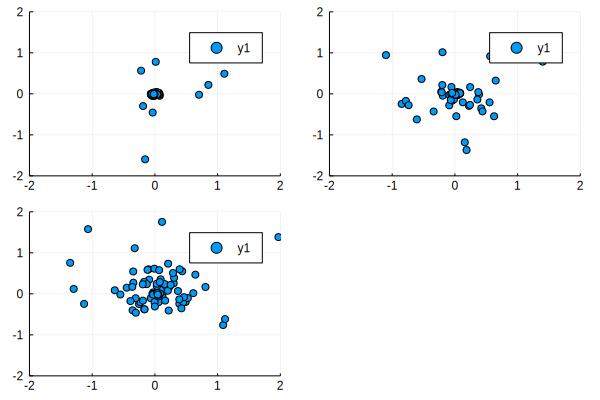

In [134]:
plot(scatter(first.(predicted_xys_1), last.(predicted_xys_1)),
    scatter(first.(predicted_xys_5), last.(predicted_xys_5)),
scatter(first.(predicted_xys_10), last.(predicted_xys_10)), link=:both, xlim=(-2,2), ylim=(-2,2))

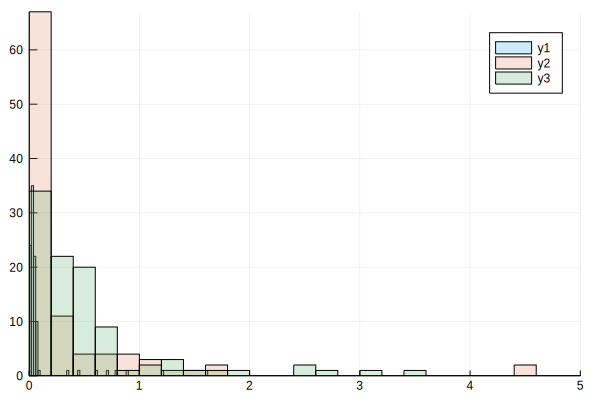

In [135]:
histogram(hcat(norm.(predicted_xys_1), norm.(predicted_xys_5), norm.(predicted_xys_10)), xlims=(0, 5), fillalpha=0.2)

In [136]:
let ps = ChenLiuParticles(100, prior_optimized, StickyCRP(10.0, 0.9))
    xy_vecs = DotLearning.extract_data(recall1, ps)
    pred_points = round.(Int, pred1[:respnr])
    pred_t = round.(Int, pred1[:pred])
    pred_samples = Vector{Vector{Vector{Float64}}}()

    i = 1
    for (pred_pt, t) in zip(pred_points, pred_t)
        while i ≤ pred_pt
            fit!(ps, xy_vecs[i])
            i += 1
        end
        push!(pred_samples, rand_posterior_future(ps, t, 100))
    end
    
    pred_samples
end

85-element Array{Array{Array{Float64,1},1},1}:
 Array{Float64,1}[[-0.0158719, -0.000685797], [-0.00699714, 0.00359554], [0.797353, -0.863915], [0.069349, 0.016135], [0.0350832, 0.0399246], [0.813231, -0.114629], [0.0328767, 0.0207118], [0.24424, -0.123912], [-0.650362, -0.0823279], [0.0357648, -0.0199378]  …  [0.193283, -0.723728], [0.61176, -0.413893], [0.0219709, -0.0274756], [0.161811, 0.510448], [0.0355897, 0.00976105], [-0.29606, -0.0236395], [-0.131818, -0.071708], [0.439253, -0.283152], [-0.550244, 0.531362], [-0.71448, -1.25705]]                                
 Array{Float64,1}[[-0.426127, -0.696301], [0.141066, 0.292197], [-0.042517, 0.422426], [0.0425283, 0.325312], [0.263187, 0.182684], [-0.0618146, 0.419617], [0.0368986, 0.0117265], [-0.150631, 0.372795], [-0.0308194, 0.305788], [1.01886, -2.53413]  …  [-1.19418, 0.548047], [0.0629212, 0.312431], [0.00394037, 0.273641], [0.0570227, 0.231043], [0.294882, -0.00769699], [-0.205292, 0.361145], [-0.0416675, 0.399877], [0.589225

In [139]:
pred_filt = DotLearning.PredictionFilter(ChenLiuParticles(100, prior_optimized, StickyCRP(10.0, 0.9)), 
                             round.(Int, pred1[:respnr]), round.(Int, pred1[:pred]), 100)

filter!(pred_filt, recall1)

datavecs = extract_data(data, pf.particles) = SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true}[[0.0318469, 0.00562752], [0.0278656, 0.000370634], [-0.0160184, -0.000520783], [0.0504518, -0.00401431], [-0.0312425, -0.000984465], [0.00850297, -0.000448522], [0.0312967, 0.00292533], [0.0355355, 0.00415872], [-0.00730868, 0.00151658], [0.0403416, -0.00260159], [0.00976546, 0.00171756], [0.0023686, 0.000115442], [0.0546225, 0.00575101], [-0.0427324, -0.0064103], [0.0409676, 0.0052352], [0.0621619, -0.0116716], [0.0356975, 0.00773563], [-0.0219736, -0.00317728], [0.00914466, -0.000840923], [0.0188237, -0.00209043], [0.147598, 0.314173], [-0.119294, 0.43221], [0.0867896, 0.278989], [0.0410898, 0.252375], [0.0120362, 0.189602], [0.0963827, 0.259921], [-0.0238888, -0.311299], [0.0342886, -0.22934], [0.00612313, -0.227477], [0.0355813, 0.00342992], [0.0174423, 0.00130537], [0.0179997, 0.00108309], [-0.0463775, -0.00790374], [0.0205501, -0.00135415], [-0.0572361, -0.010025

DotLearning.PredictionFilter{Particles.ChenLiuParticles{Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.StickyCRP}}}(Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.StickyCRP}[19+ Particle, 20+ Particle, 19+ Particle, 19+ Particle, 19+ Particle, 19+ Particle, 21+ Particle, 19+ Particle, 19+ Particle, 21+ Particle  …  21+ Particle, 20+ Particle, 20+ Particle, 19+ Particle, 19+ Particle, 19+ Particle, 19+ Particle, 19+ Particle, 19+ Particle, 19+ Particle], [20, 23, 26, 26, 29, 29, 32, 35, 35, 38  …  182, 182, 185, 188, 188, 191, 194, 197, 200, 200], [10, 1, 5, 10, 1, 10, 1, 5, 10, 1  …  5, 10, 1, 5, 10, 1, 5, 1, 5, 10], 100, Array{Array{Float64,1},1}[Array{Float64,1}[[0.778159, 0.809897], [0.414918, 0.13054], [0.24221, 0.046895], [0.158933, -0.295618], [0.287182, 0.106268], [0.696954, 2.24575], [0.286661, -0.278743], [-0.0238495, 0.0221729], [0.0179355, -0.386357

Particle filter with 100 particles:


In [140]:
pred_filt.predictions

85-element Array{Array{Array{Float64,1},1},1}:
 Array{Float64,1}[[0.778159, 0.809897], [0.414918, 0.13054], [0.24221, 0.046895], [0.158933, -0.295618], [0.287182, 0.106268], [0.696954, 2.24575], [0.286661, -0.278743], [-0.0238495, 0.0221729], [0.0179355, -0.386357], [0.310273, -2.04686]  …  [0.173104, 0.295208], [0.029427, -0.00944359], [-1.49237, 1.2419], [0.0460739, 0.0136104], [-0.900944, 1.60944], [-0.571874, 0.554946], [2.72895, -0.897174], [0.613274, 0.57796], [0.0449569, -0.0172071], [0.0234369, 0.00835242]]                                                           
 Array{Float64,1}[[0.0919904, 0.219512], [-0.0541105, 0.365996], [0.247904, 0.237832], [0.0819801, 0.302522], [0.0914776, 0.234483], [-0.392378, 0.751115], [0.0119629, 0.255804], [0.227563, -0.270454], [-0.082225, 0.422041], [0.163543, 0.371951]  …  [0.102601, 0.278442], [-0.0779666, 0.336783], [-0.0419789, 0.352142], [-0.126224, 0.305367], [-0.109728, 0.347357], [-0.0112012, 0.382892], [0.386872, 0.0267862], [0.1030

How do we want to save the summary of the predictions?  In `model_recall` we create a DataFrame with one row per recall data point.  Probably want to return the recall dataframe _and_ some dataframe summary of the prediction.  Could just "un-nest" the predictions...

In [7]:

@load "results/run3-2018-07-18T12:40:07.059.jld2" expts results

LoadError: [91mKeyError: key "recall_predict" not found[39m